# IF3170 Artificial Intelligence | Praktikum

This notebook serves as a template for the assignment. Please create a copy of this notebook to complete your work. You can add more code blocks, markdown blocks, or new sections if needed.


Group Number: 21

Group Members:
- Denise Felicia Tiowanni (13522013)
- Erdianti Wiga Putri Andini (13522053)

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import *
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, log_loss, accuracy_score, f1_score
from sklearn.preprocessing import label_binarize

## Import Dataset

In [ ]:
test_data = 'https://drive.google.com/uc?id=1k7kmkB-3vkrU5CTDhEVBOxV2VXrnL5ue'
train_data = 'https://drive.google.com/uc?id=1BE2Wt0hd0QZTcHWDJN1f94in-Kq0C6AO'

test = pd.read_csv(test_data)
train = pd.read_csv(train_data)

# 1. Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a crucial step in the data analysis process that involves examining and visualizing data sets to uncover patterns, trends, anomalies, and insights. It is the first step before applying more advanced statistical and machine learning techniques. EDA helps you to gain a deep understanding of the data you are working with, allowing you to make informed decisions and formulate hypotheses for further analysis.

In [ ]:
print("----- DATA SIZE -----")
data_size = train.shape
size_table = pd.DataFrame({
    'Instances': [data_size[0]],
    'Features': [data_size[1]]
})
display(size_table)

print("\n----- DATA TYPES -----")
types_table = pd.DataFrame(train.dtypes)
display(types_table)

----- DATA SIZE -----


,Instances,Features
0,15000,20



----- DATA TYPES -----


,0
id,int64
N_Days,float64
Drug,object
Age,float64
Sex,object
Ascites,object
Hepatomegaly,object
Spiders,object
Edema,object
Bilirubin,float64


In [ ]:
# CATEGORICAL DATA
categorical_data = train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_data = [col for col in categorical_data if col != 'id']  # id ga masuk karena cuma identifier
categorical_data.append('Stage')

unique_counts = train[['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage', 'Status']].nunique()

unique_categorical = pd.DataFrame(unique_counts).reset_index()
unique_categorical.columns = ['Category', 'Unique Counts']

print("----- UNIQUE COUNTS (CATEGORICAL) -----")
display(unique_categorical)

----- UNIQUE COUNTS (CATEGORICAL) -----


,Category,Unique Counts
0,Drug,2
1,Sex,2
2,Ascites,2
3,Hepatomegaly,3
4,Spiders,2
5,Edema,3
6,Stage,4
7,Status,3


In [ ]:
# CATEGORICAL DATA
print("\n----- VALUE DISTRIBUTION PER DATA (CATEGORICAL) -----")
for column in categorical_data:
    print(f"{column.upper()}")
    value_distribution = train[column].value_counts()
    proportion_distribution = train[column].value_counts(normalize=True) * 100
    distribution_table = pd.DataFrame({
        'Count': value_distribution,
        'Proportion (%)': proportion_distribution
    })
    display(distribution_table)


----- VALUE DISTRIBUTION PER DATA (CATEGORICAL) -----
DRUG


,Count,Proportion (%)
Drug,,
D-penicillamine,4515,53.431953
Placebo,3935,46.568047


SEX


,Count,Proportion (%)
Sex,,
F,14405,96.033333
M,595,3.966667


ASCITES


,Count,Proportion (%)
Ascites,,
N,8027,94.960369
Y,426,5.039631


HEPATOMEGALY


,Count,Proportion (%)
Hepatomegaly,,
N,4652,55.066288
Y,3795,44.921875
158.0,1,0.011837


SPIDERS


,Count,Proportion (%)
Spiders,,
N,6598,78.166094
Y,1843,21.833906


EDEMA


,Count,Proportion (%)
Edema,,
N,13874,92.493333
S,737,4.913333
Y,389,2.593333


STATUS


,Count,Proportion (%)
Status,,
C,10117,67.446667
D,4525,30.166667
CL,358,2.386667


STAGE


,Count,Proportion (%)
Stage,,
3.0,5530,36.866667
4.0,5235,34.900000
2.0,3456,23.040000
1.0,779,5.193333


In [ ]:
# NUMERICAL DATA
numerical_data = [col for col in train.columns if col not in categorical_data and col != 'id']

summary_stats = train[numerical_data].describe().loc[['min', '25%', '50%', '75%', 'max', 'mean', 'std']]
summary_stats.rename(index={'50%': 'median'}, inplace=True)
print("----- SUMMARY STATISTICS (NUMERICAL) -----")
display(summary_stats)

----- SUMMARY STATISTICS (NUMERICAL) -----


,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
min,10.800000,174.000000,0.300000,120.000000,1.960000,0.900000,3.410000,0.900000,11.000000,0.900000,4.160000
25%,1092.000000,16463.000000,0.700000,242.000000,3.290000,31.000000,721.000000,71.000000,80.000000,189.000000,10.100000
median,1783.000000,19577.000000,0.900000,280.000000,3.580000,52.000000,1072.000000,97.650000,99.000000,251.000000,10.600000
75%,2615.000000,22388.000000,1.800000,360.000000,3.770000,89.000000,1689.000000,130.200000,133.000000,312.000000,11.000000
max,25976.000000,91894.000000,28.000000,1790.000000,4.700000,604.000000,18102.000000,12285.000000,608.000000,3150.000000,18.000000
mean,1969.116920,19298.427133,1.862907,322.805916,3.520585,76.395725,1676.897656,108.214094,110.670418,254.266294,10.624837
std,1374.093322,3706.122475,2.763713,163.041117,0.373807,76.662546,1882.904216,152.099011,49.828478,96.081587,0.729726


In [ ]:
# MISSING VALUES
missing_counts = train.isnull().sum()
missing_percentage = (missing_counts / len(train)) * 100
missing_summary = pd.DataFrame({'Missing Values': missing_counts, 'Percentage': missing_percentage})
print("\n----- Missing Values -----:")
display(missing_summary)


----- Missing Values -----:


,Missing Values,Percentage
id,0,0.000000
N_Days,0,0.000000
Drug,6550,43.666667
Age,0,0.000000
Sex,0,0.000000
Ascites,6547,43.646667
Hepatomegaly,6552,43.680000
Spiders,6559,43.726667
Edema,0,0.000000
Bilirubin,0,0.000000



----- NUMERICAL DATA OUTLIERS BY IQR (True indicates an outlier) -----


,0
N_Days,True
Age,True
Bilirubin,True
Cholesterol,True
Albumin,True
Copper,True
Alk_Phos,True
SGOT,True
Tryglicerides,True
Platelets,True



----- JUMLAH OUTLIER PER KOLOM NUMERICAL -----


,0
N_Days,35
Age,16
Bilirubin,1577
Cholesterol,384
Albumin,353
Copper,695
Alk_Phos,845
SGOT,208
Tryglicerides,291
Platelets,136



----- VISUALIZATION NUMERICAL DATA OUTLIERS -----


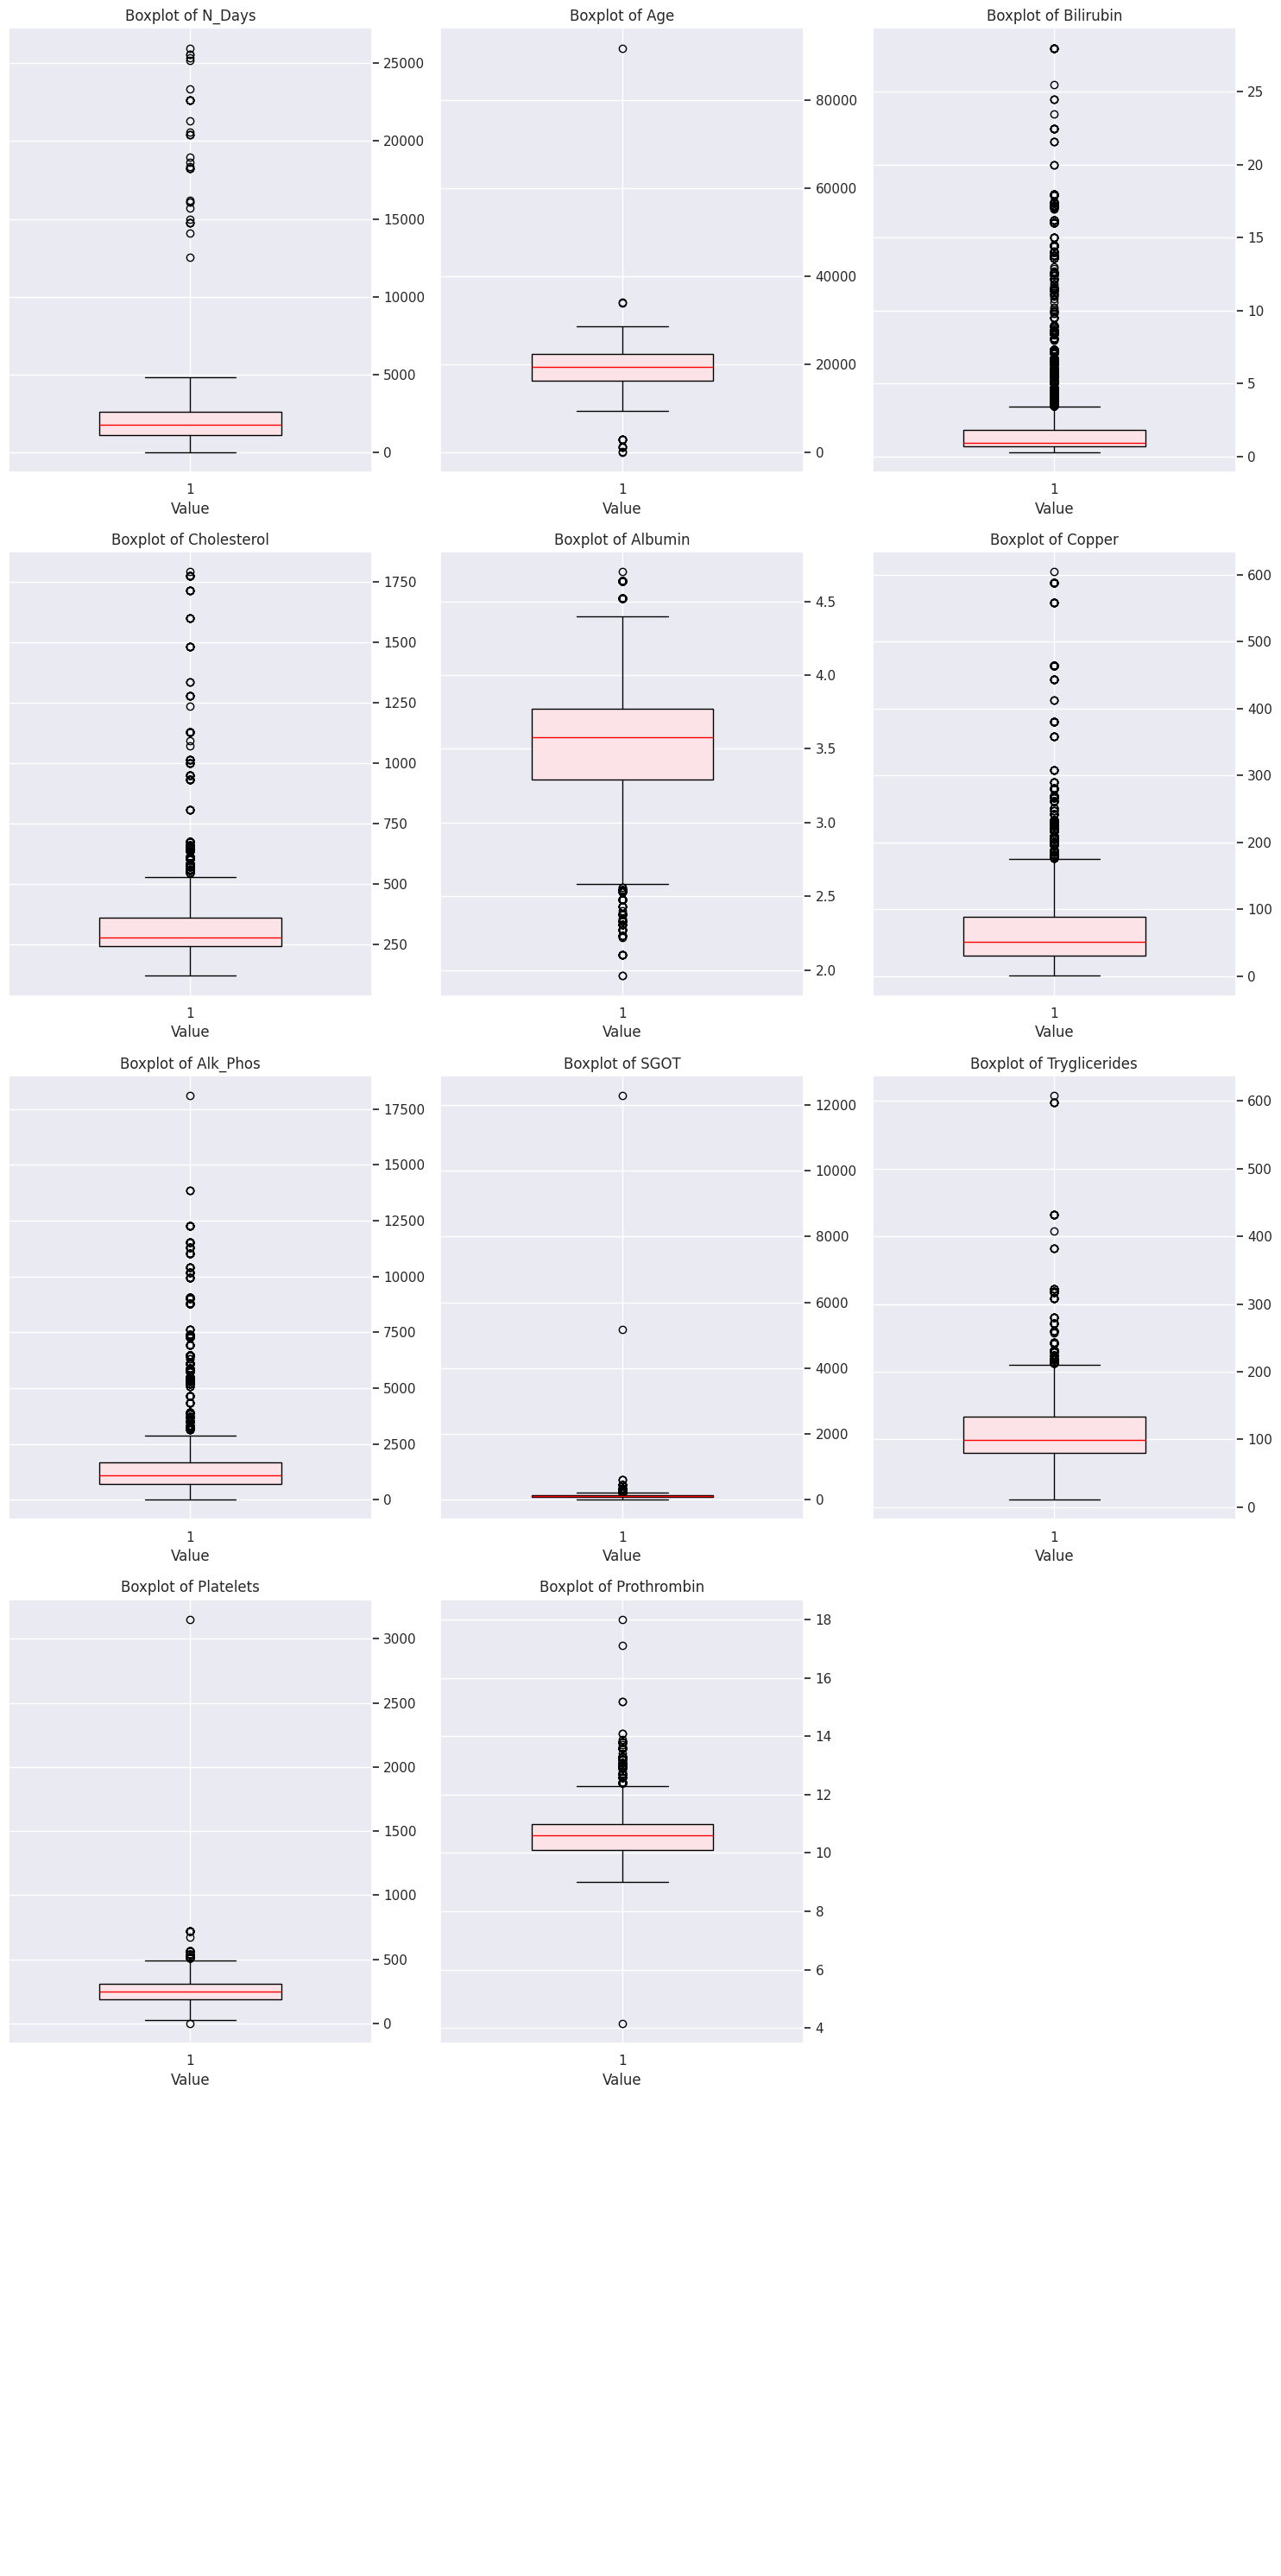

In [ ]:
# Outliers for Numerical
print("\n----- NUMERICAL DATA OUTLIERS BY IQR (True indicates an outlier) -----")
df_numeric = train[numerical_data]

# IQR
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = (df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))
display(outliers_iqr.any())

# Jumlah outlier dalam data numerik berdasarkan IQR
print("\n----- JUMLAH OUTLIER PER KOLOM NUMERICAL -----")
outliers_count_per_column = outliers_iqr.sum()
display(outliers_count_per_column)

print("\n----- VISUALIZATION NUMERICAL DATA OUTLIERS -----")
sns.set(style="darkgrid")

num_columns = df_numeric.columns.size
num_rows = (num_columns // 3) + (num_columns % 3)
fig, ax = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 6 * num_rows))
ax = ax.flatten()

for i, column in enumerate(df_numeric.columns):
    ax[i].boxplot(df_numeric[column].dropna(), vert=True, widths=0.5, patch_artist=True,
                    boxprops=dict(facecolor='#fbe3e7', color='black'), medianprops=dict(color='red'))
    ax[i].set_title(f'Boxplot of {column}')
    ax[i].set_xlabel('Value')
    ax[i].yaxis.tick_right()

for j in range(i + 1, len(ax)):
    ax[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Outliers for Categorical

df_categorical = train[categorical_data]
rare_category_results = {}
for column in df_categorical:
    frequency = train[column].value_counts(normalize=True)
    threshold = 0.01
    rare_categories = frequency[frequency < threshold]
    rare_category_results[column] = rare_categories

print("\nRARE CATEGORIES IN NON-NUMERICAL DATA:")
for column, rare_cats in rare_category_results.items():
    if not rare_cats.empty:
        print(f"\nRare categories in {column.upper()} (less than {threshold * 100}%):")
        display(rare_cats)
    else:
        print(f"\nNo rare categories detected in {column} that fall below the {threshold * 100}% threshold.")


RARE CATEGORIES IN NON-NUMERICAL DATA:

No rare categories detected in Drug that fall below the 1.0% threshold.

No rare categories detected in Sex that fall below the 1.0% threshold.

No rare categories detected in Ascites that fall below the 1.0% threshold.

Rare categories in HEPATOMEGALY (less than 1.0%):


,proportion
Hepatomegaly,
158.0,0.000118



No rare categories detected in Spiders that fall below the 1.0% threshold.

No rare categories detected in Edema that fall below the 1.0% threshold.

No rare categories detected in Status that fall below the 1.0% threshold.

No rare categories detected in Stage that fall below the 1.0% threshold.


In [ ]:
# CORRELATION
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

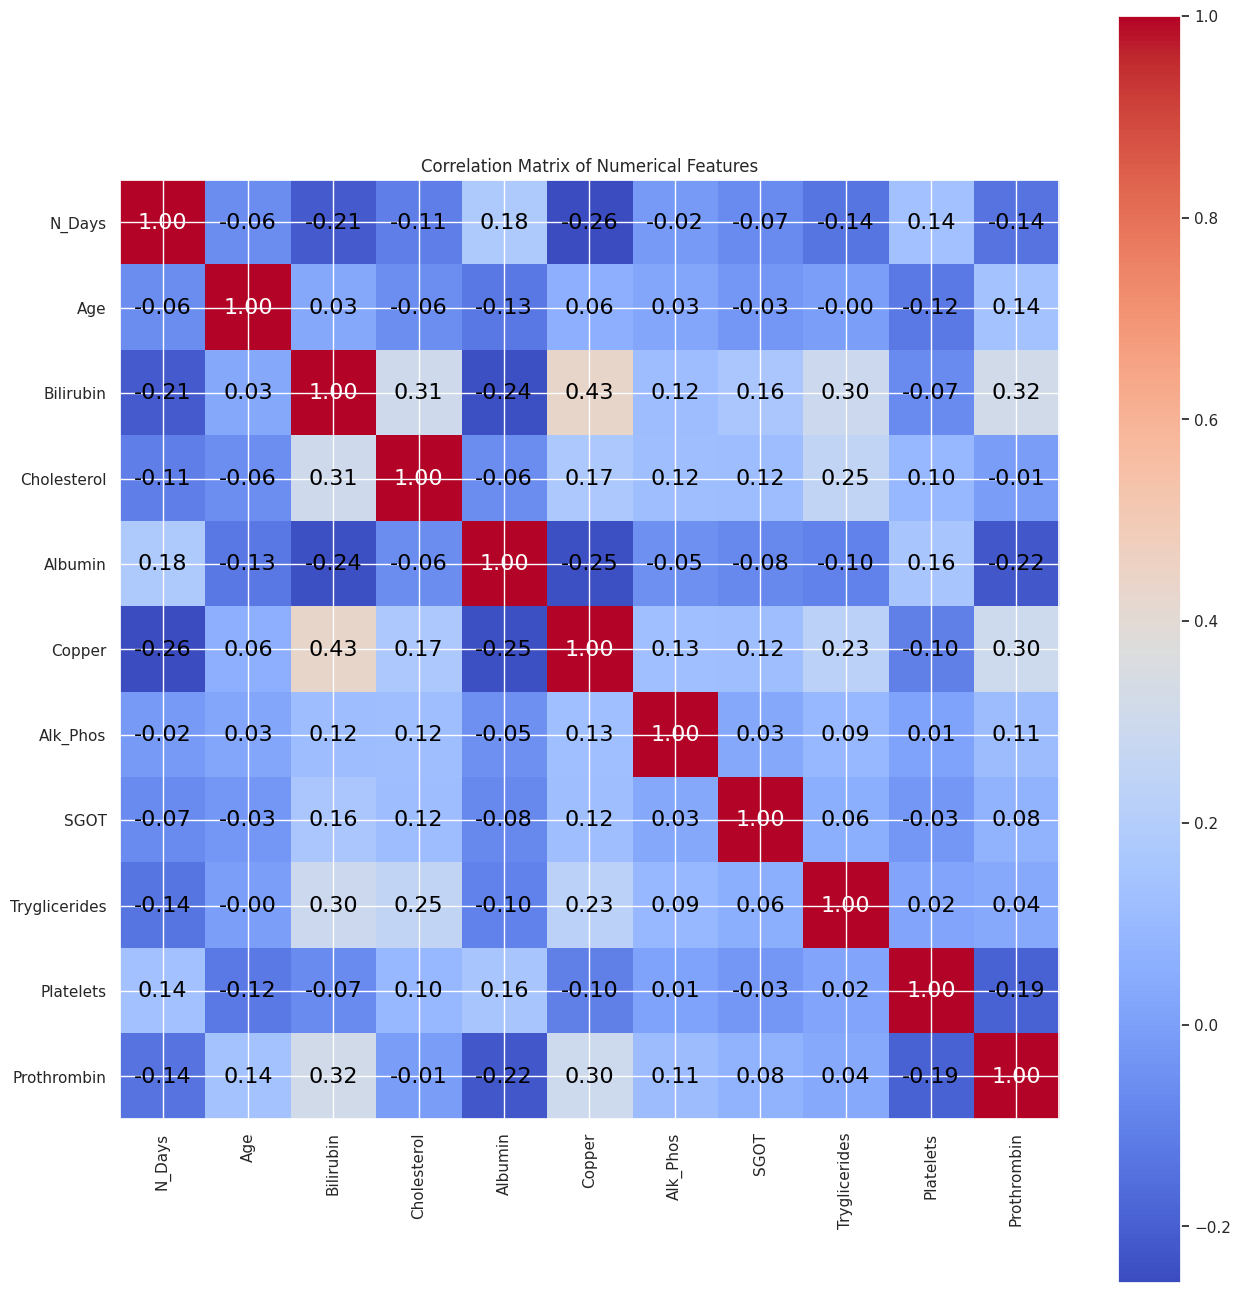

In [ ]:
# NUMERICAL DATA
correlation_matrix = df_numeric.corr()

fig, ax = plt.subplots(figsize=(len(correlation_matrix.columns)*1.2, len(correlation_matrix.columns)*1.2))

cax = ax.imshow(correlation_matrix, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax)

ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=90)
ax.set_yticklabels(correlation_matrix.columns)

for (i, j), val in np.ndenumerate(correlation_matrix):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white' if abs(val) > 0.5 else 'black', fontsize=16)

plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

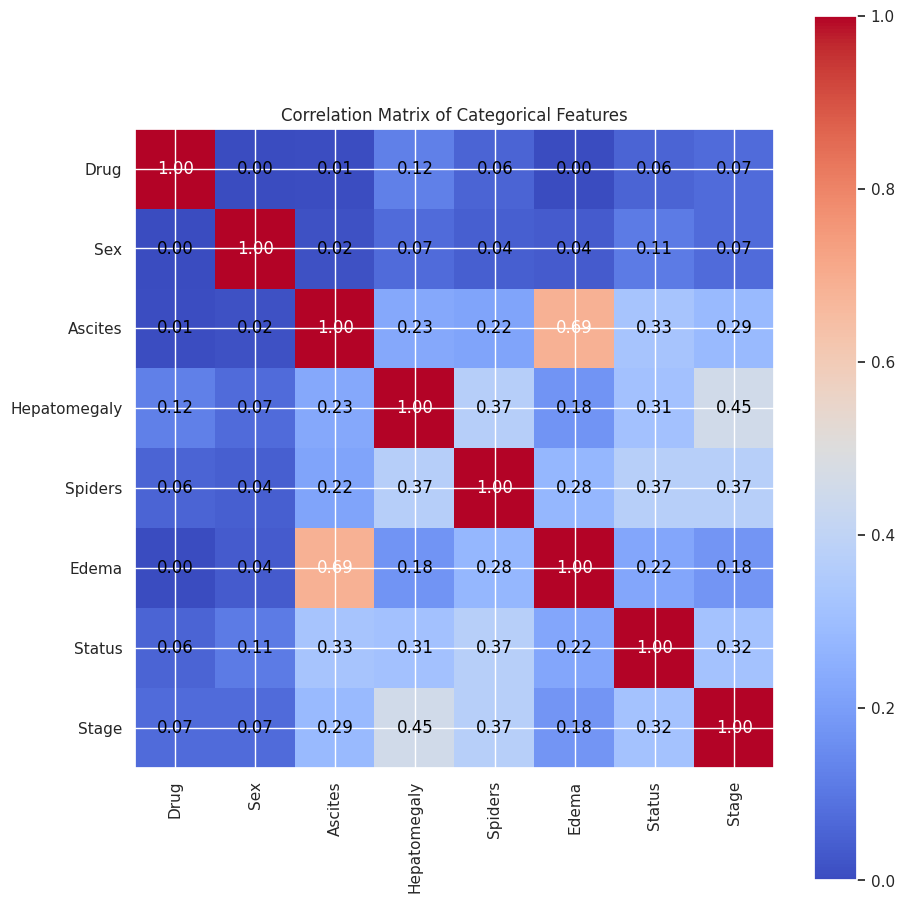

In [ ]:
# CATEGORICAL DATA
cat_columns = train[categorical_data].columns
cramers = {col: {col2: cramers_v(train[col], train[col2]) for col2 in cat_columns} for col in cat_columns}
cramers_v_matrix = pd.DataFrame(cramers)

fig, ax = plt.subplots(figsize=(len(cramers_v_matrix.columns)*1.2, len(cramers_v_matrix.columns)*1.2))
cax = ax.imshow(cramers_v_matrix, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax)

ax.set_xticks(np.arange(len(cramers_v_matrix.columns)))
ax.set_yticks(np.arange(len(cramers_v_matrix.columns)))
ax.set_xticklabels(cramers_v_matrix.columns, rotation=90)
ax.set_yticklabels(cramers_v_matrix.columns)

for (i, j), val in np.ndenumerate(cramers_v_matrix):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white' if abs(val) > 0.5 else 'black', fontsize=12)

plt.title('Correlation Matrix of Categorical Features')
plt.tight_layout()
plt.show()

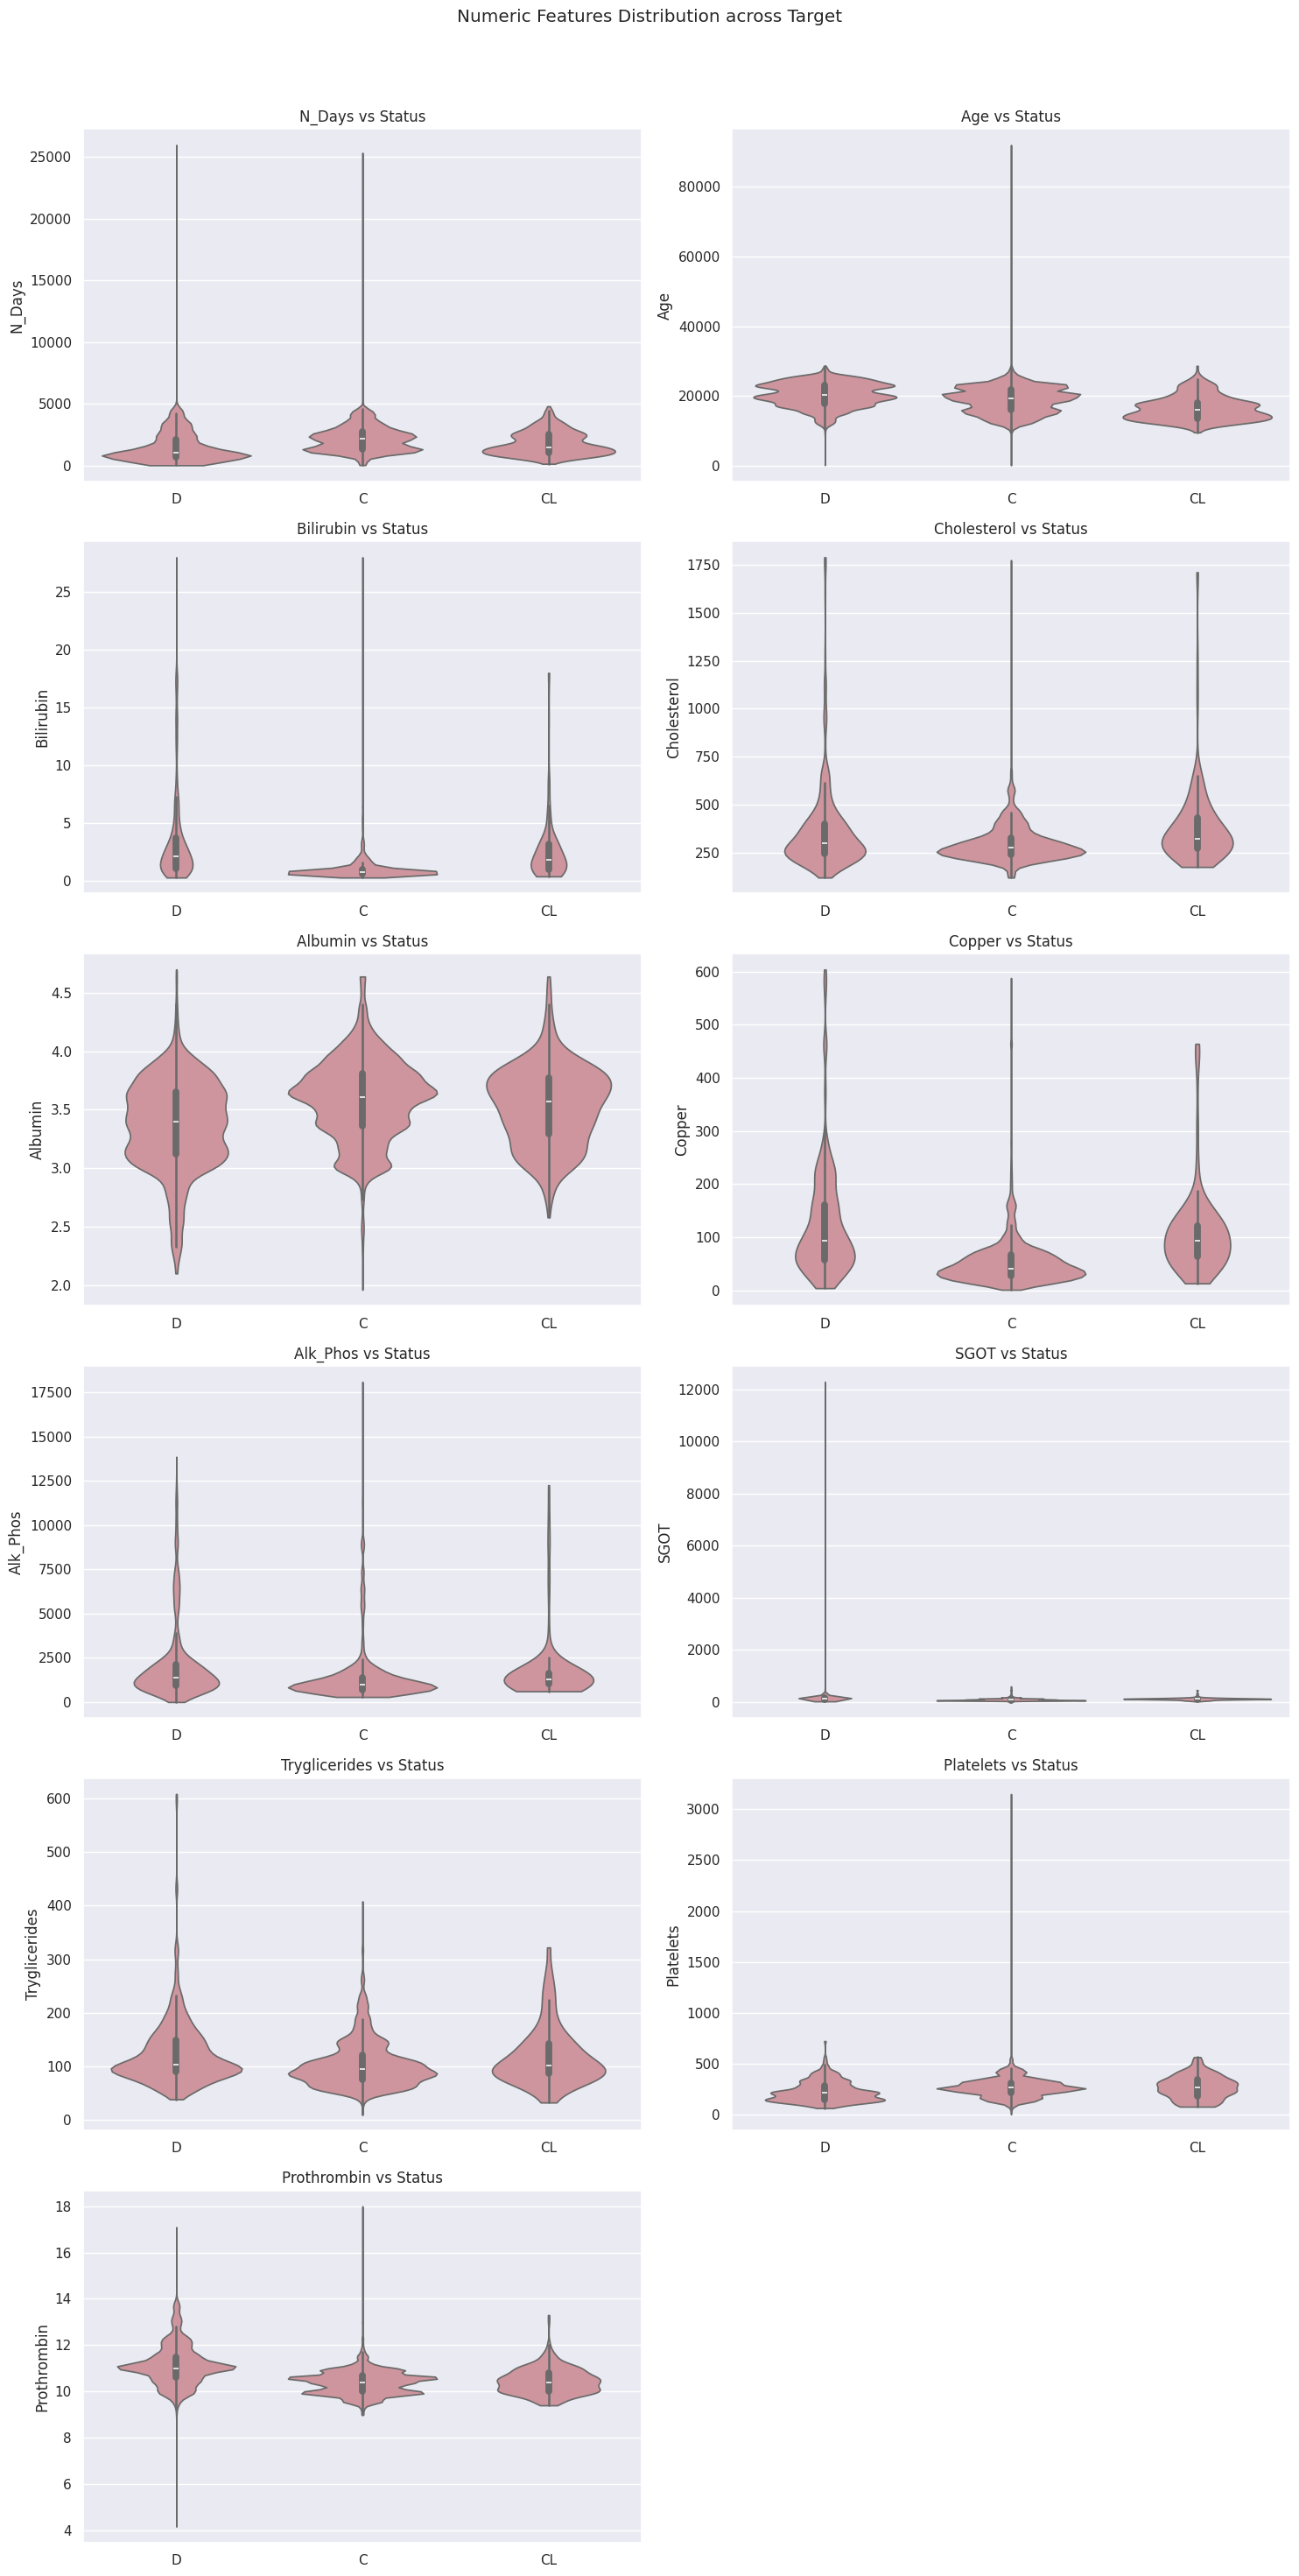

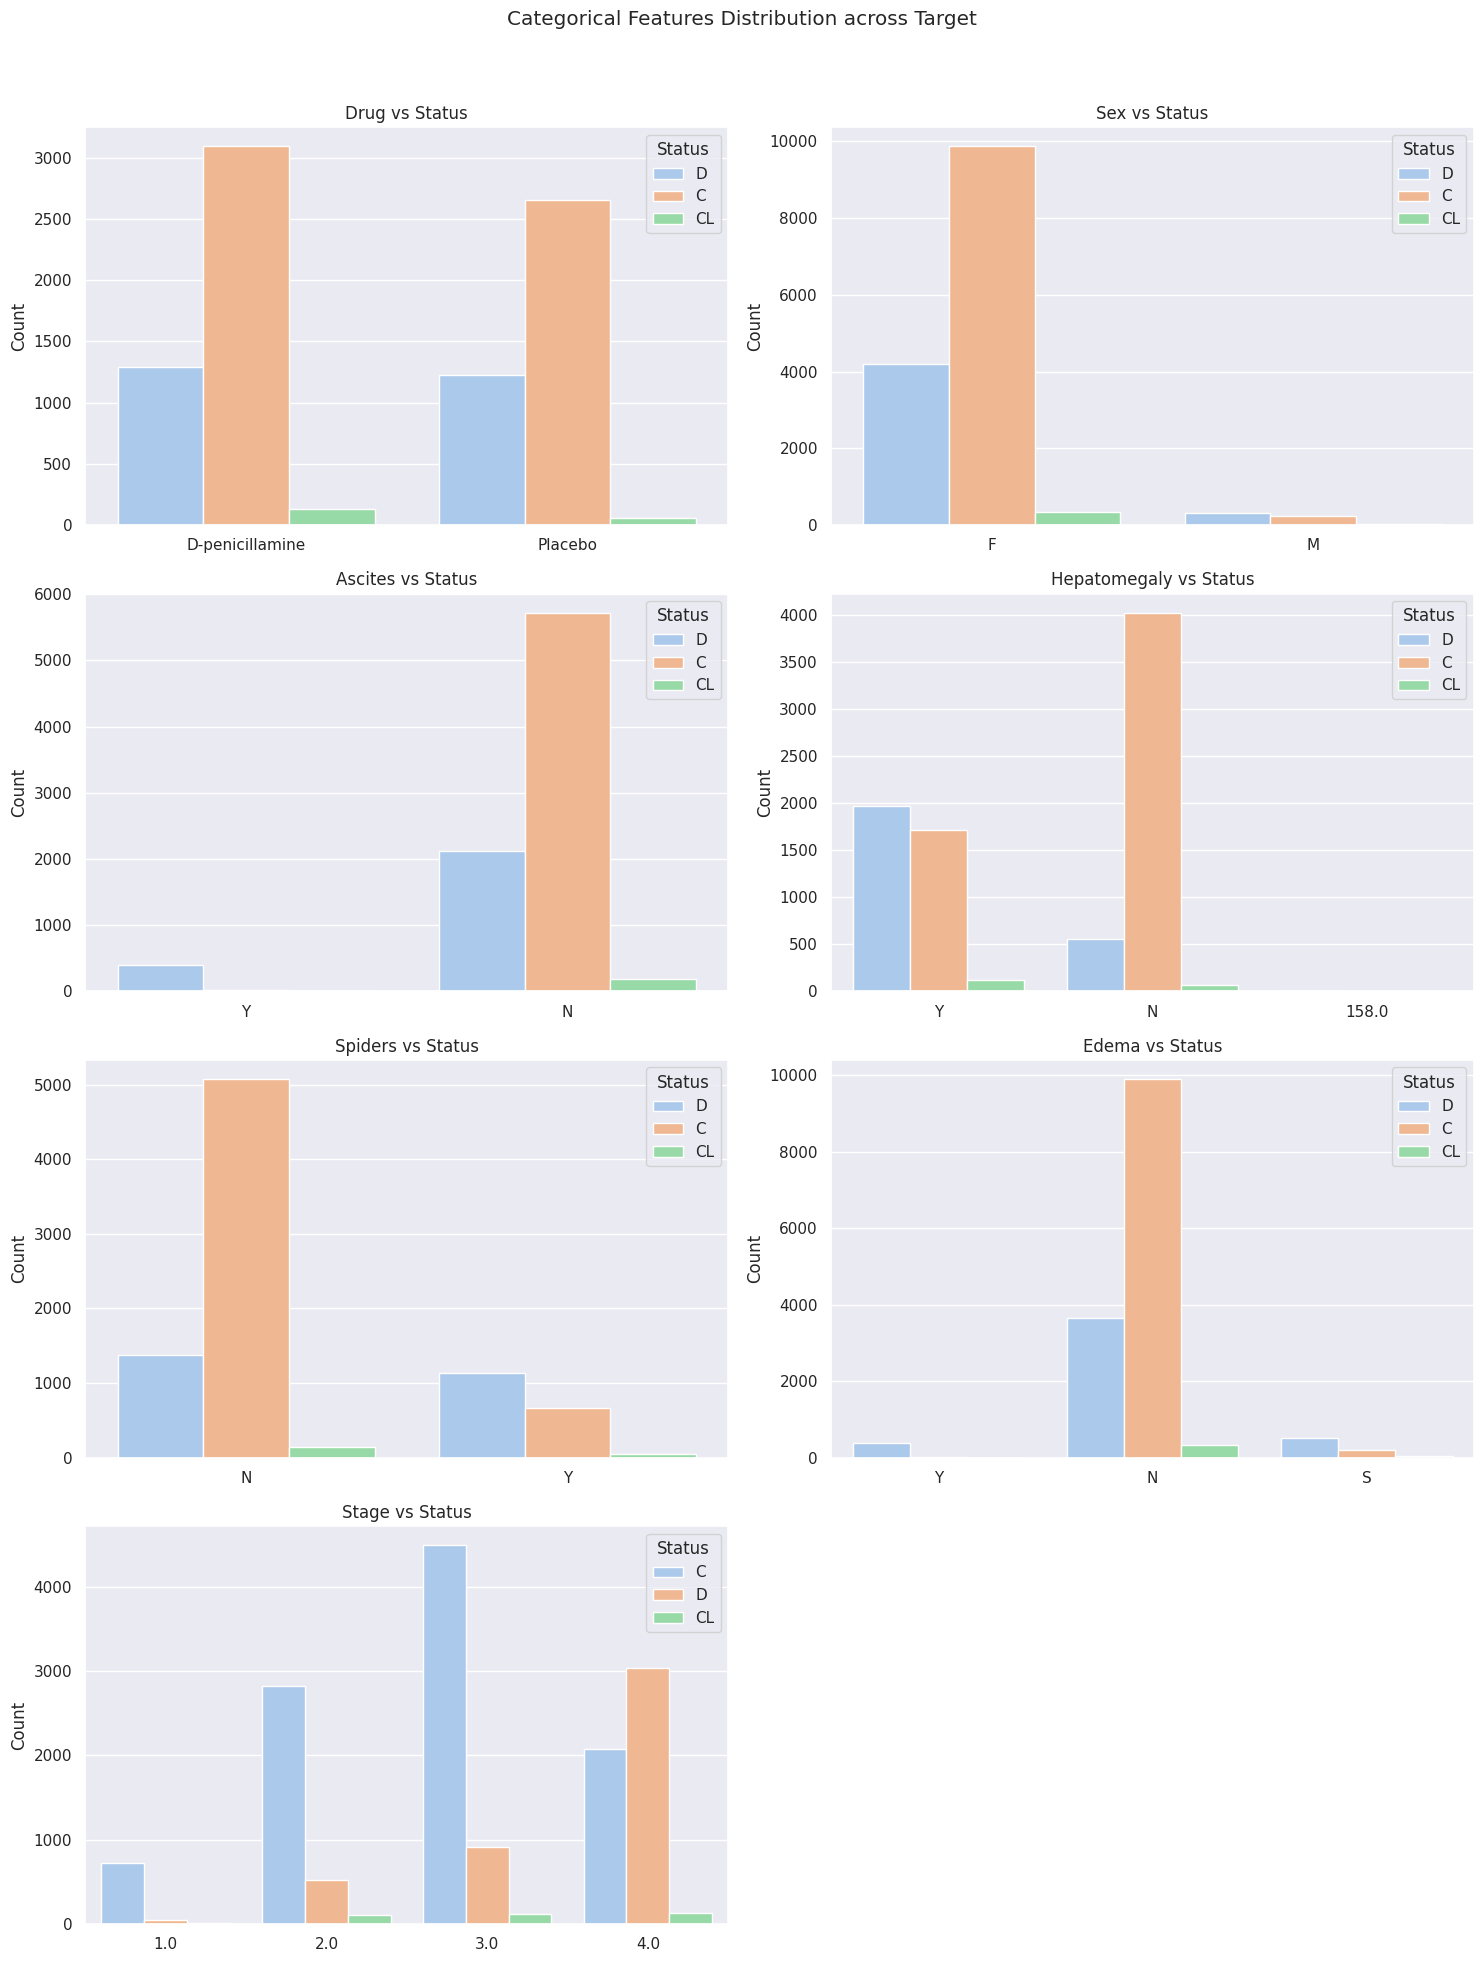

In [ ]:
# CORRELATION BETWEEN FEATURES N TARGET
target = 'Status'

numerical_data = [feat for feat in numerical_data if feat != target]
categorical_data = [feat for feat in categorical_data if feat != target]

# Numerical Data Plot
num_columns = 2
num_rows_numeric = math.ceil(len(numerical_data) / num_columns)
fig, axes = plt.subplots(num_rows_numeric, num_columns, figsize=(15, 5 * num_rows_numeric), squeeze=False)
fig.suptitle('Numeric Features Distribution across Target')

idx = 0
for feature in numerical_data:
    ax = axes[idx // num_columns, idx % num_columns]
    sns.violinplot(ax=ax, x=target, y=feature, data=train, cut=0, color='#d88b98')
    ax.set_title(f'{feature} vs {target}')
    ax.set_xlabel('')
    ax.set_ylabel(feature)
    idx += 1

# Hide empty subplots if any
for i in range(idx, num_rows_numeric * num_columns):
    axes[i // num_columns, i % num_columns].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Categorical Data Plot
num_rows_categorical = math.ceil(len(categorical_data) / num_columns)
fig, axes = plt.subplots(num_rows_categorical, num_columns, figsize=(15, 5 * num_rows_categorical), squeeze=False)
fig.suptitle('Categorical Features Distribution across Target')

idx = 0
for feature in categorical_data:
    ax = axes[idx // num_columns, idx % num_columns]
    sns.countplot(ax=ax, x=feature, hue=target, data=train, palette="pastel")
    ax.set_title(f'{feature} vs {target}')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.legend(title=target, loc='upper right')
    idx += 1

for i in range(idx, num_rows_categorical * num_columns):
    axes[i // num_columns, i % num_columns].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

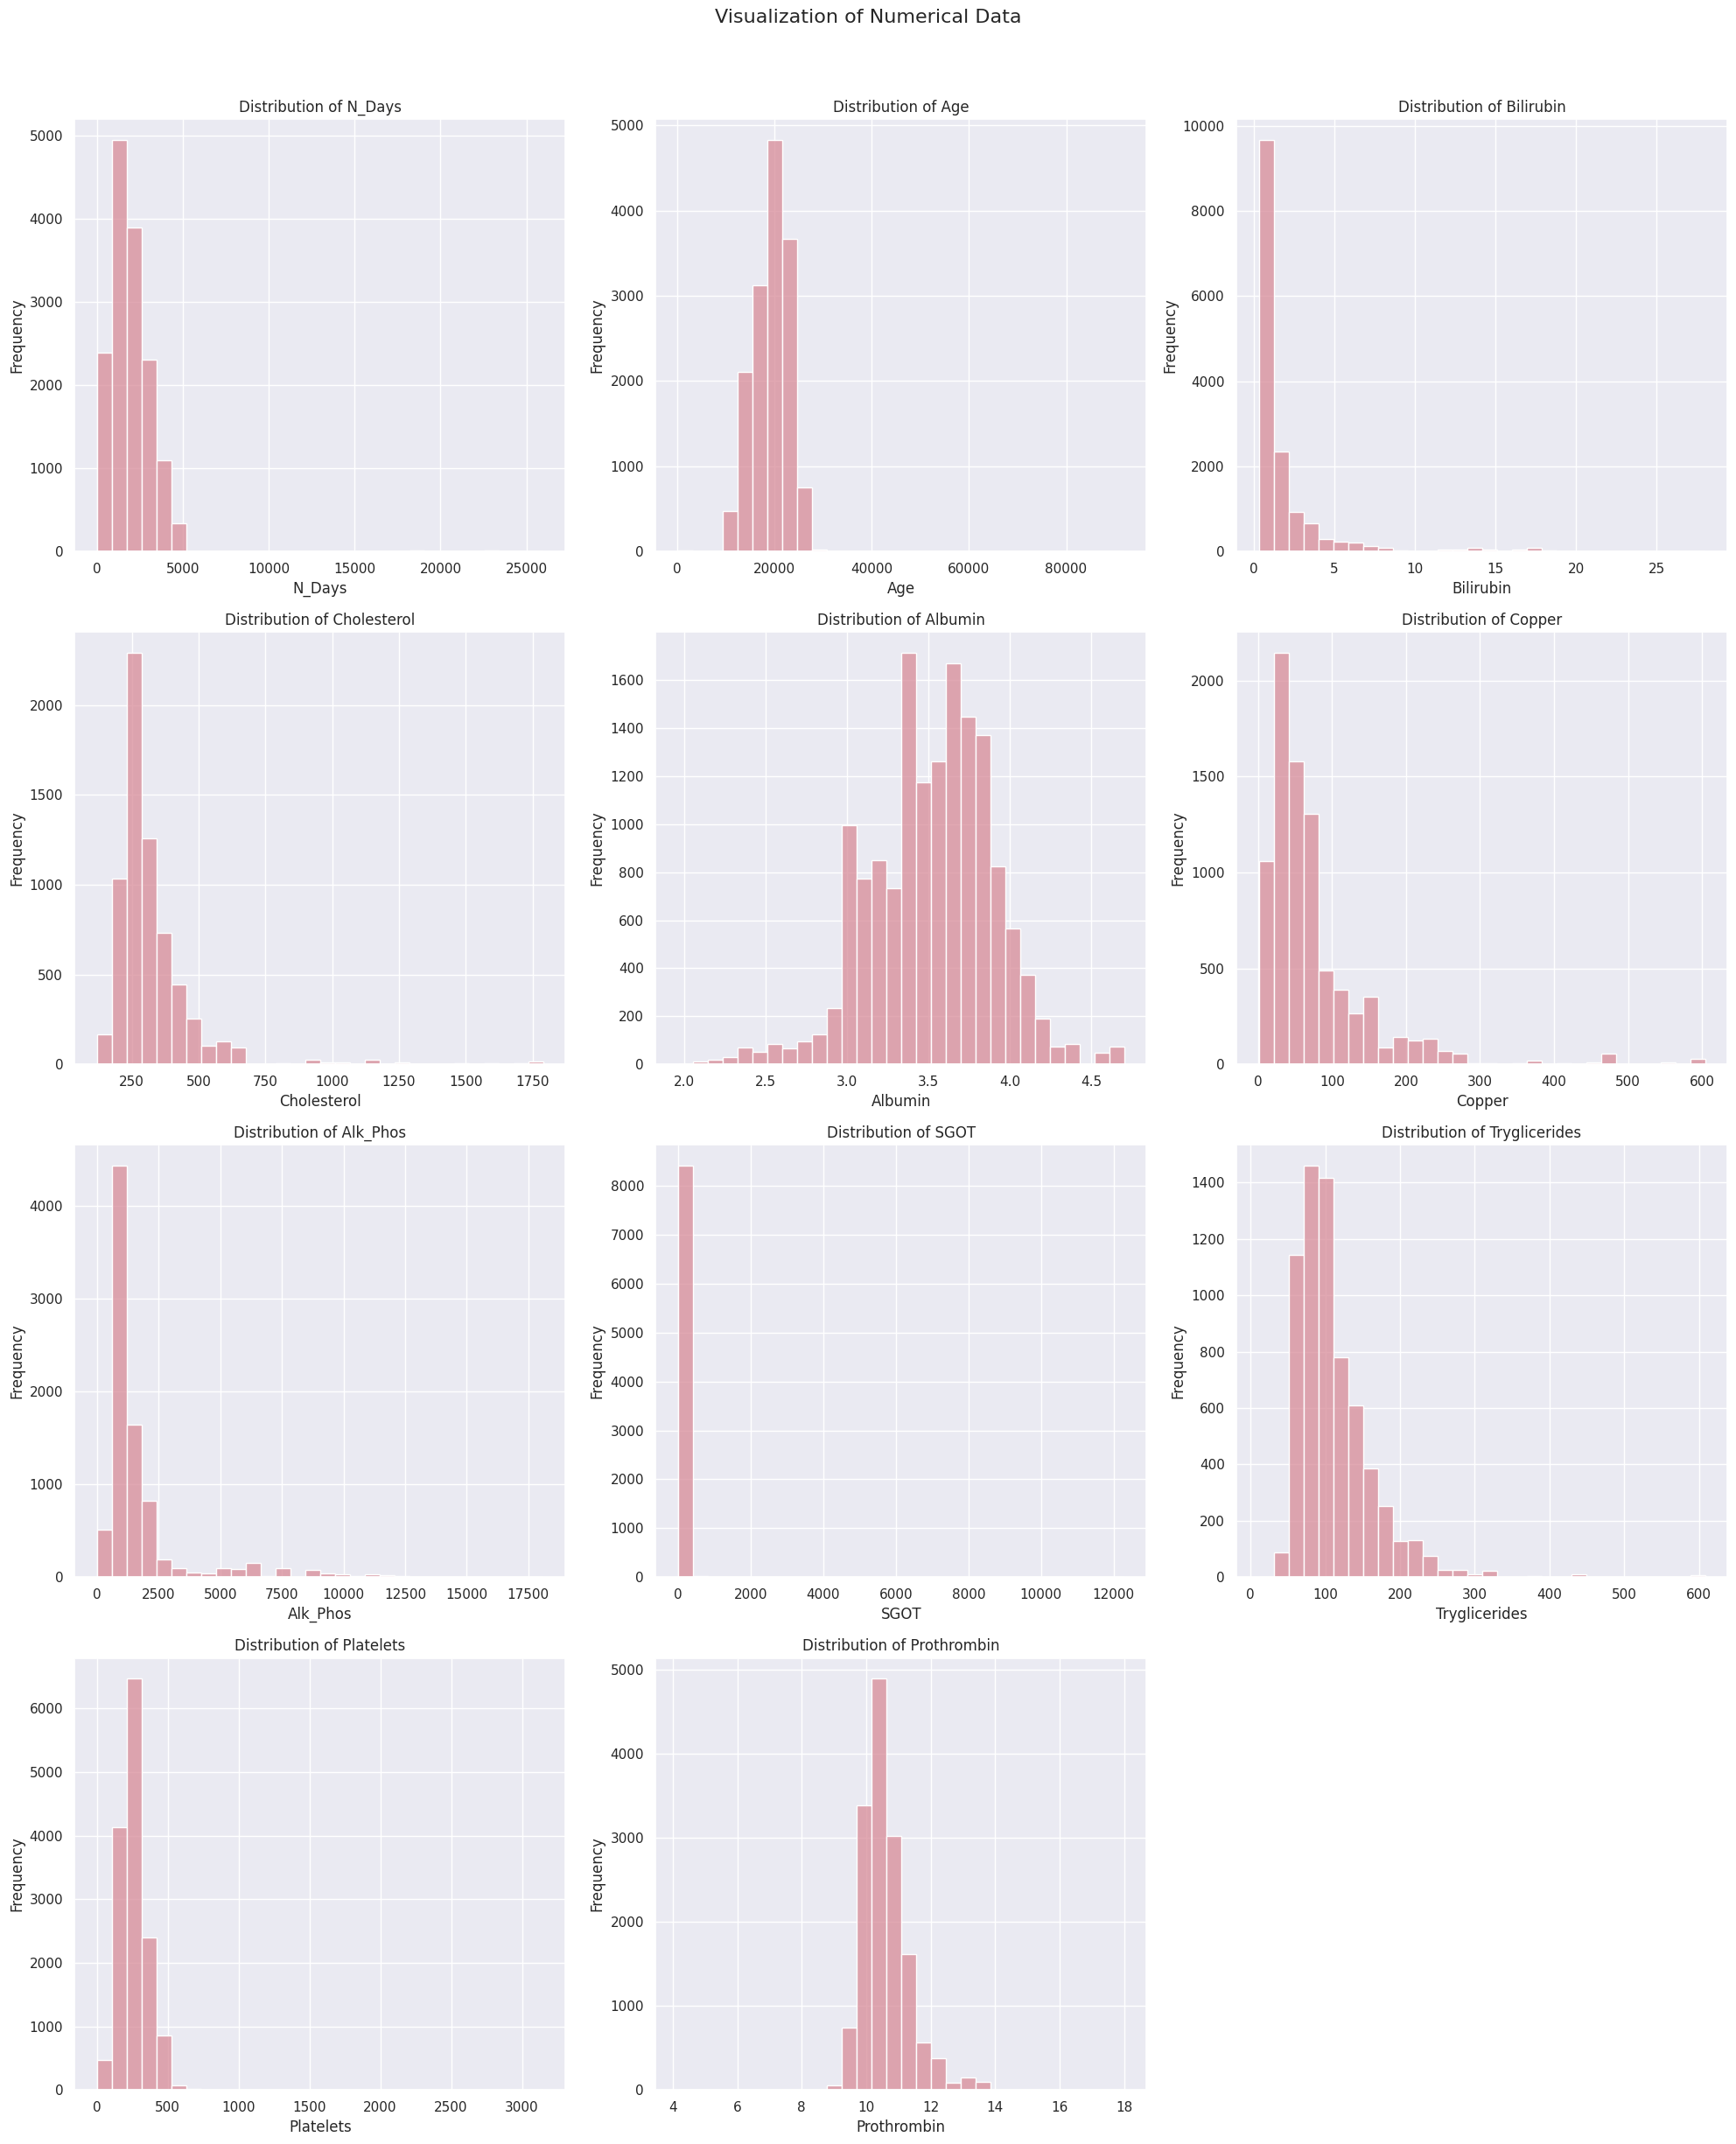

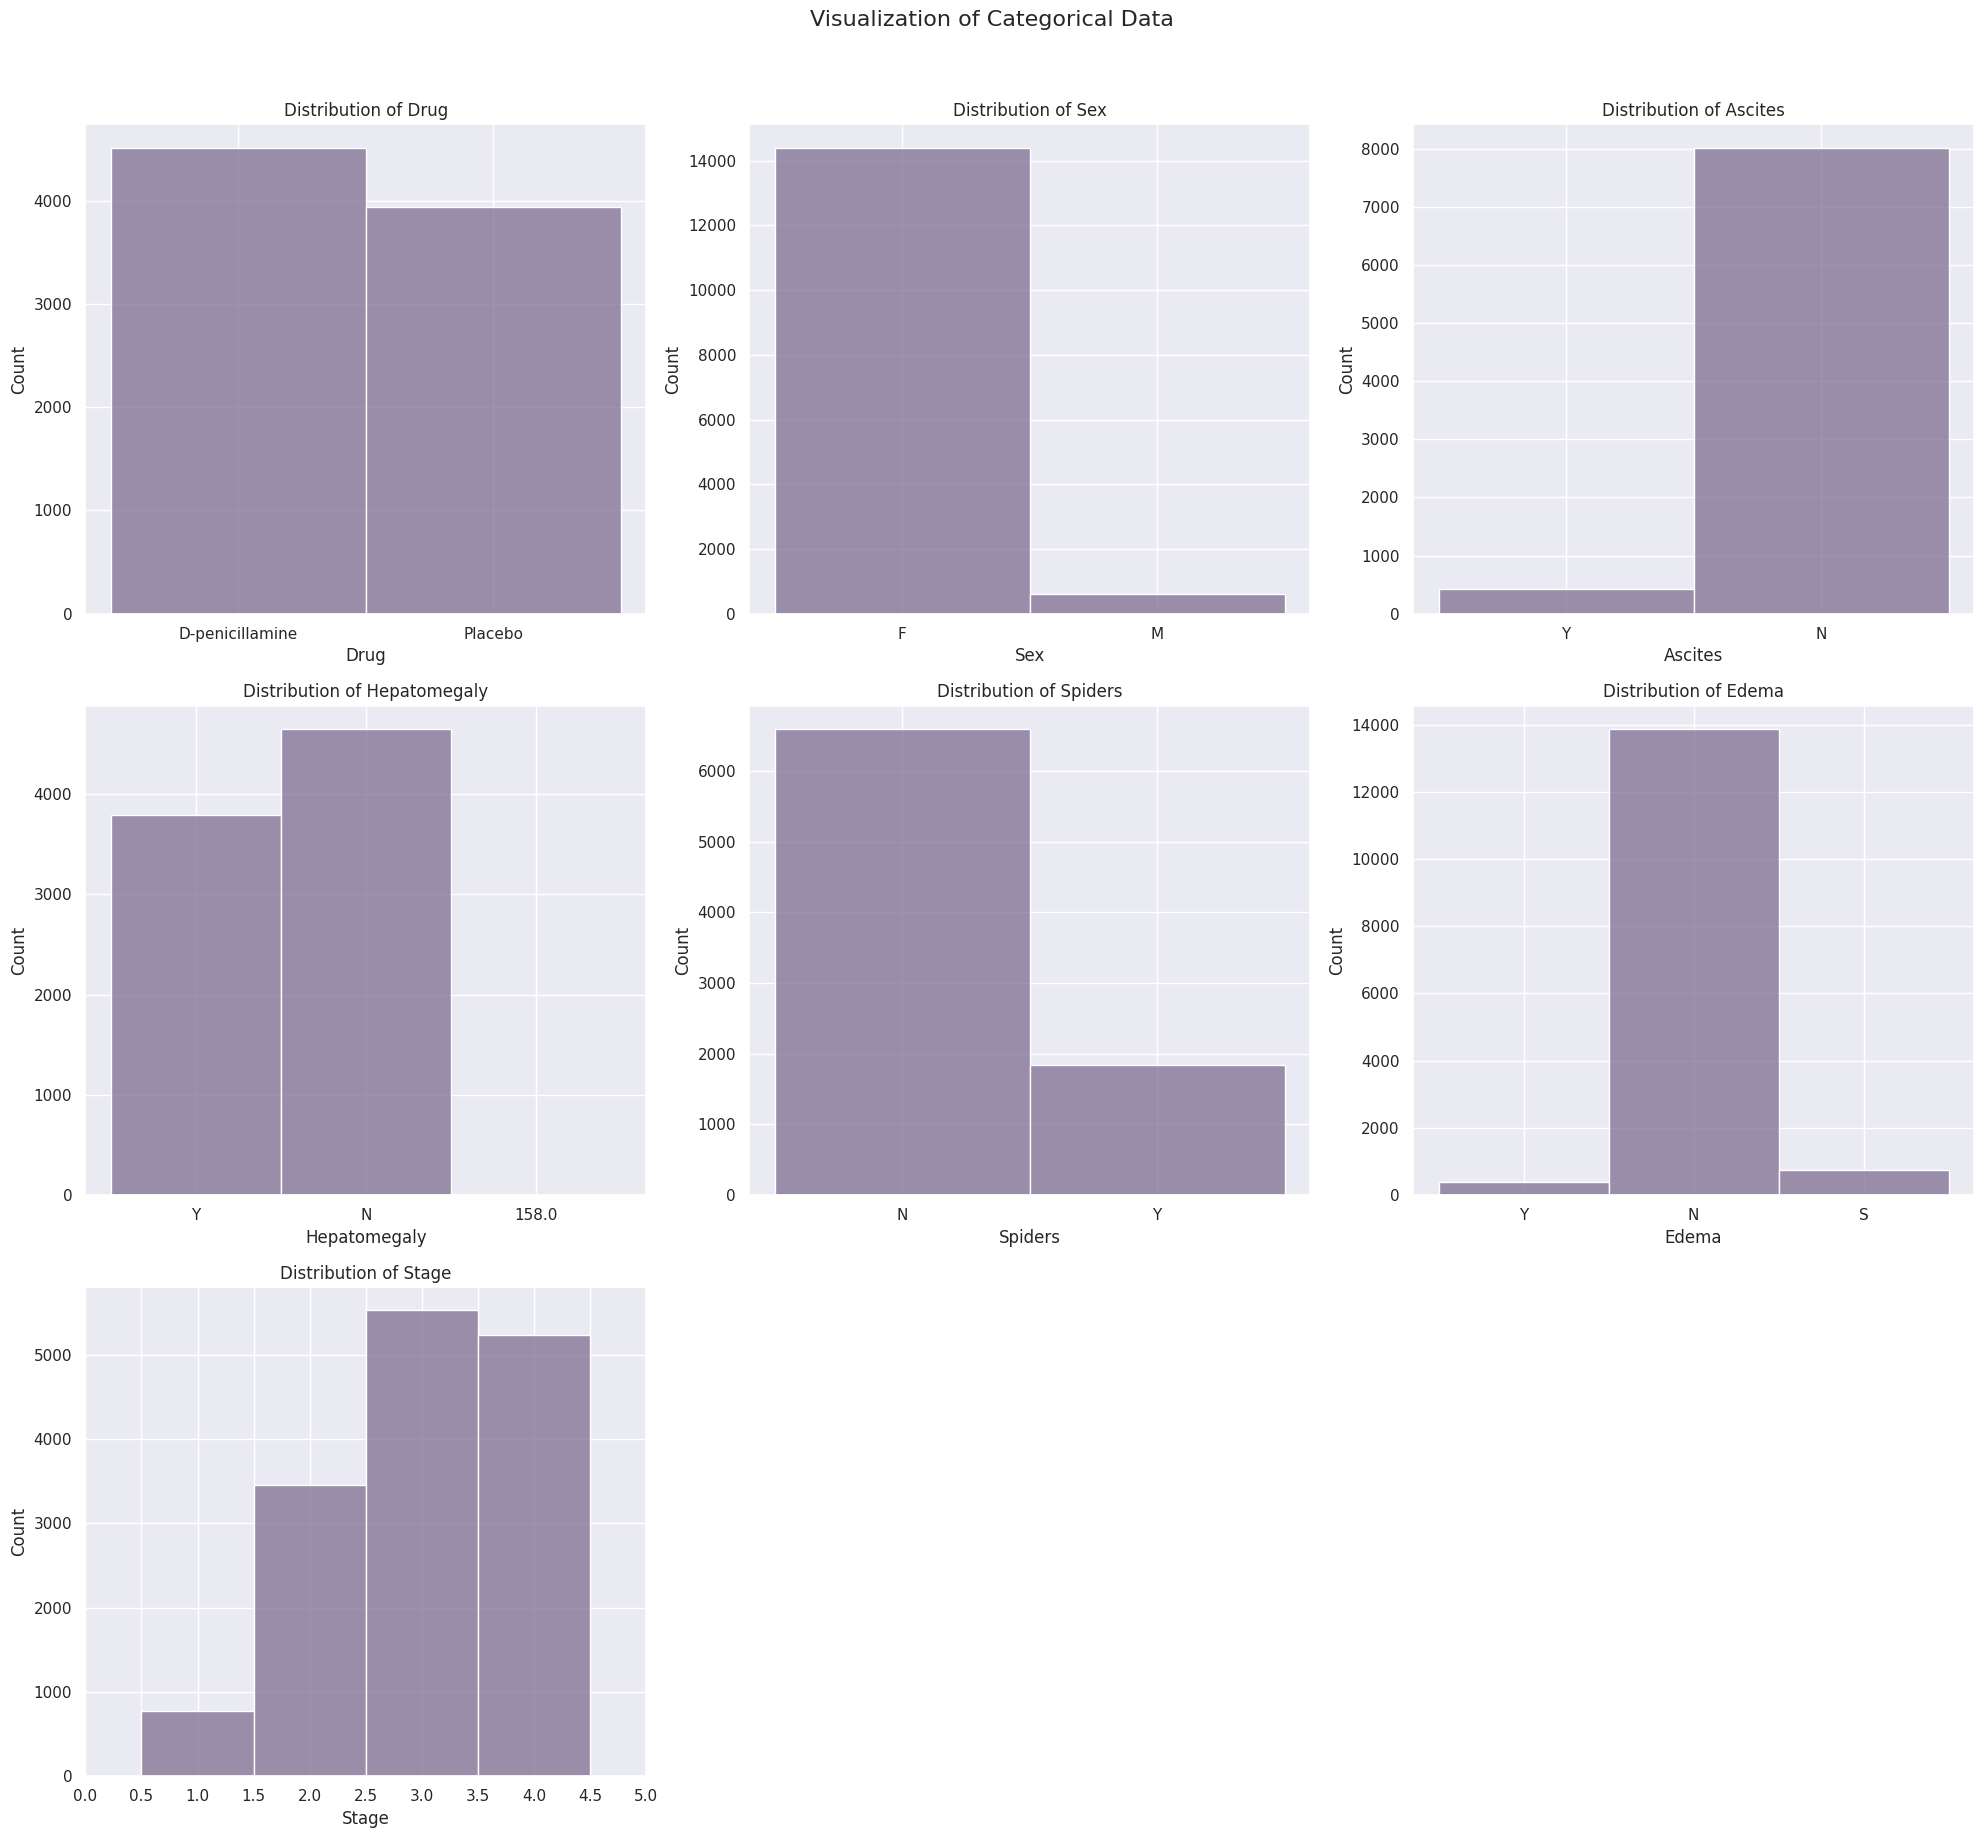

In [ ]:
# DATA VISUALIZATION

num_columns = 3
num_numerical_cols = len(numerical_data)
num_rows_numerical = math.ceil(num_numerical_cols / num_columns)
fig, axes = plt.subplots(num_rows_numerical, num_columns, figsize=(20, 6 * num_rows_numerical))

# Numerical Data Plotting
for i, col in enumerate(numerical_data):
    ax = axes.flatten()[i]
    sns.histplot(train[col], bins=30, color='#d88b98', kde=False, ax=ax)
    ax.set_title(f'Distribution of {col}', fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

for ax in axes.flatten()[num_numerical_cols:]:
    ax.set_visible(False)

fig.suptitle('Visualization of Numerical Data', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Categorical Data Plotting
num_categorical_cols = len(categorical_data)
num_categorical_rows = math.ceil(num_categorical_cols / num_columns)
fig, axes = plt.subplots(num_categorical_rows, num_columns, figsize=(20, 6 * num_categorical_rows))

for i, col in enumerate(categorical_data):
    ax = axes.flatten()[i]
    sns.histplot(data=train, x=col, discrete=True, color='#7e6e92', ax=ax)
    ax.set_title(f'Distribution of {col}', fontsize=12)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels([tick.get_text() for tick in ax.get_xticklabels()], rotation=0)
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

for ax in axes.flatten()[num_categorical_cols:]:
    ax.set_visible(False)

fig.suptitle('Visualization of Categorical Data', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# 2. Split Training Set and Validation Set

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. If you want to use k-fold cross-validation, split the data later and do the cleaning and preprocessing separately for each split.

Note: For training, you should use the data contained in the `train.csv` given by the TA. The `test.csv` data is only used for kaggle submission.

In [ ]:
def check_distribution(y_data, set_name):
    dist = y_data.value_counts(normalize=True)
    print(f"\nClass distribution in {set_name} set:")
    print(dist)

# Define column types
target_col = ['Status']
cat_columns = train.select_dtypes(include=['object']).columns.tolist()
cat_columns.append('Stage')
indices_to_drop = [i for i, val in enumerate(cat_columns) if val in target_col]
cat_columns = np.delete(cat_columns, indices_to_drop)
num_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_columns = [col for col in num_columns if col not in ['Stage', 'id']]

# Original data
x = train.drop(target_col, axis=1)
y = train[target_col]

# Split data into training and test sets (hold-out validation)
x_train, x_val, y_train, y_val = train_test_split(
    x,
    y,
    test_size=0.2,  # 80% training, 20% test
    random_state=42,
    stratify=y
)

print(f"Training Set Size: {x_train.shape}, Test Set Size: {x_val.shape}")

# Check class distributions
check_distribution(y, "original")
check_distribution(y_train, "training")
check_distribution(y_val, "test")

# Save splits
# x_train.to_csv('x_train_holdout.csv', index=False)
# y_train.to_csv('y_train_holdout.csv', index=False)
# x_val.to_csv('x_val.csv', index=False)
# y_val.to_csv('y_val.csv', index=False)

Training Set Size: (12000, 19), Test Set Size: (3000, 19)

Class distribution in original set:
Status
C         0.674467
D         0.301667
CL        0.023867
Name: proportion, dtype: float64

Class distribution in training set:
Status
C         0.674500
D         0.301667
CL        0.023833
Name: proportion, dtype: float64

Class distribution in test set:
Status
C         0.674333
D         0.301667
CL        0.024000
Name: proportion, dtype: float64


# 3. Data Cleaning and Preprocessing

This step is the first thing to be done once a Data Scientist have grasped a general knowledge of the data. Raw data is **seldom ready for training**, therefore steps need to be taken to clean and format the data for the Machine Learning model to interpret.

By performing data cleaning and preprocessing, you ensure that your dataset is ready for model training, leading to more accurate and reliable machine learning results. These steps are essential for transforming raw data into a format that machine learning algorithms can effectively learn from and make predictions.

For each step that you will do, **please explain the reason why did you do that process. Write it in a markdown cell under the code cell you wrote.**

In [ ]:
# check for missing values
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()

print("missing values in train data:")
print(missing_train[missing_train > 0])

# percentage
for column in missing_train[missing_train > 0].index:
    print(f"{column}: {missing_train[column] / train.shape[0] * 100:.2f}%")

print("\nmissing values in test data:")
print(missing_test[missing_test > 0])

missing values in train data:
Drug             6550
Ascites          6547
Hepatomegaly     6552
Spiders          6559
Cholesterol      8374
Copper           6660
Alk_Phos         6556
SGOT             6559
Tryglicerides    8425
Platelets         584
Prothrombin        16
dtype: int64
Drug: 43.67%
Ascites: 43.65%
Hepatomegaly: 43.68%
Spiders: 43.73%
Cholesterol: 55.83%
Copper: 44.40%
Alk_Phos: 43.71%
SGOT: 43.73%
Tryglicerides: 56.17%
Platelets: 3.89%
Prothrombin: 0.11%

missing values in test data:
N_Days              1
Drug             4368
Ascites          4365
Hepatomegaly     4372
Spiders          4373
Cholesterol      5625
Copper           4440
Alk_Phos         4374
SGOT             4374
Tryglicerides    5657
Platelets         390
Prothrombin        10
dtype: int64


In [ ]:
print("categorical features:")
print(cat_columns)

print("\nnumerical features:")
print(num_columns)

categorical features:
['Drug' 'Sex' 'Ascites' 'Hepatomegaly' 'Spiders' 'Edema' 'Stage']

numerical features:
['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']


In [ ]:
# check unique values in categorical features
for col in cat_columns:
    print(f"unique values in {col}:")
    print(train[col].value_counts())
    print()

unique values in Drug:
Drug
D-penicillamine    4515
Placebo            3935
Name: count, dtype: int64

unique values in Sex:
Sex
F    14405
M      595
Name: count, dtype: int64

unique values in Ascites:
Ascites
N    8027
Y     426
Name: count, dtype: int64

unique values in Hepatomegaly:
Hepatomegaly
N        4652
Y        3795
158.0       1
Name: count, dtype: int64

unique values in Spiders:
Spiders
N    6598
Y    1843
Name: count, dtype: int64

unique values in Edema:
Edema
N    13874
S      737
Y      389
Name: count, dtype: int64

unique values in Stage:
Stage
3.0    5530
4.0    5235
2.0    3456
1.0     779
Name: count, dtype: int64



In [ ]:
# check for skewness
print("Skewness of each column in numerical:")
for column in num_columns:
    print(column, ":", train[column].skew())

Skewness of each column in numerical:
N_Days : 5.723226588086048
Age : 0.2501326957918793
Bilirubin : 4.228548344977254
Cholesterol : 4.499543223972586
Albumin : -0.30018987991930035
Copper : 3.115699180745672
Alk_Phos : 3.1538951588374986
SGOT : 65.28128415449646
Tryglicerides : 2.368980642200841
Platelets : 2.340967199225039
Prothrombin : 1.2436597583866906


In [ ]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # median is more robust to outliers than mean
    ('power_transform', PowerTransformer(standardize=True)),  # handle skewed features
    ('scaler', RobustScaler())  # more robust to outliers than StandardScaler
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # explicitly mark missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.01))  # ignore rare categories
])

# 3. Compile Preprocessing Pipeline

All of the preprocessing classes or functions defined earlier will be compiled in this step.

If you use sklearn to create preprocessing classes, you can list your preprocessing classes in the Pipeline object sequentially, and then fit and transform your data.

In [ ]:
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, num_columns),
    ('cat', categorical_pipeline, cat_columns)
])

In [ ]:
X_train_processed = preprocessor.fit_transform(x_train)
X_val_processed = preprocessor.transform(x_val)

In [ ]:
# test data
test[numerical_data]

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
0,1525.0,20392.0,3.5,373.0,3.43,281.0,1523.0,188.34,193.0,227.0,12.3
1,111.0,23011.0,0.6,NaN,3.69,NaN,NaN,NaN,NaN,280.0,10.8
2,2149.0,23376.0,0.6,NaN,3.50,NaN,NaN,NaN,NaN,425.0,10.3
3,2249.0,15706.0,0.6,NaN,3.76,NaN,NaN,NaN,NaN,225.0,10.5
4,3231.0,18263.0,0.8,NaN,3.14,NaN,NaN,NaN,NaN,173.0,10.8
...,...,...,...,...,...,...,...,...,...,...,...
9995,3358.0,16374.0,0.8,263.0,3.37,31.0,1268.0,126.42,85.0,173.0,10.6
9996,797.0,21904.0,1.1,260.0,3.53,102.0,979.0,137.00,113.0,128.0,10.2
9997,727.0,24107.0,14.0,NaN,3.40,NaN,NaN,NaN,NaN,150.0,11.1
9998,41.0,24064.0,4.5,175.0,3.19,112.0,3292.0,215.45,229.0,332.0,13.2


# 4. Modeling and Validation

Modelling is the process of building your own machine learning models to solve specific problems, or in this assignment context, predicting the probability for each class in the `Status` feature (`Status_C`, `Status_CL`, `Status_D`). Validation is the process of evaluating your trained model using the validation set or cross-validation method and providing some metrics that can help you decide what to do in the next iteration of development.

In [ ]:
def plot_model_performance(model, X_train, X_val, y_train, y_val, model_name="Model"):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)

    class_names = ['C', 'CL', 'D']

    # 1. Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=class_names, yticklabels=class_names)
    ax1.set_title(f'{model_name} Confusion Matrix')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')

    # 2. ROC Curve (one-vs-rest)
    y_val_bin = label_binarize(y_val, classes=np.unique(y_val))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    for i in range(len(class_names)):
        ax2.plot(fpr[i], tpr[i],
                 label=f'Class {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title(f'{model_name} ROC Curves')
    ax2.legend(loc="lower right")

    # 3. K-value vs Log Loss (only for KNN) or Feature Importance
    best_k = None
    best_loss = None

    if isinstance(model, KNeighborsClassifier):
        k_values = range(1, 21)
        log_losses = []

        for k in k_values:
            temp_model = KNeighborsClassifier(n_neighbors=k)
            temp_model.fit(X_train, y_train)
            temp_pred_proba = temp_model.predict_proba(X_val)
            log_losses.append(log_loss(y_val, temp_pred_proba))

        ax3.plot(k_values, log_losses, marker='o')
        ax3.set_xlabel('Number of Neighbors (k)')
        ax3.set_ylabel('Log Loss')
        ax3.set_title('K-value vs Log Loss')

        best_k = k_values[np.argmin(log_losses)]
        best_loss = min(log_losses)
    else:
        # Check for feature importance
        try:
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
            elif hasattr(model, 'get_feature_importance'):
                importances = model.get_feature_importance()
            else:
                raise AttributeError

            # Generate feature names
            if isinstance(X_train, np.ndarray):
                feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]
            else:
                feature_names = X_train.columns.tolist()

            # Plot feature importance
            importance_data = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            })
            importance_data = importance_data.sort_values('Importance', ascending=True)

            ax3.barh(range(len(importance_data)), importance_data['Importance'])
            ax3.set_yticks(range(len(importance_data)))
            ax3.set_yticklabels(importance_data['Feature'])
            ax3.set_xlabel('Importance')
            ax3.set_title('Feature Importance')

        except (AttributeError, TypeError):
            ax3.text(0.5, 0.5, 'No K-values or feature importance available',
                    ha='center', va='center')
            ax3.axis('off')

    plt.tight_layout()
    plt.show()

    # Print metrics
    print(f"\n{model_name} Performance Metrics:")
    print(f"Log Loss: {log_loss(y_val, y_pred_proba):.4f}")
    print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    print(f"Macro F1-Score: {f1_score(y_val, y_pred, average='macro'):.4f}")

    if best_k is not None:
        print(f"\nBest k value: {best_k} with Log Loss: {best_loss:.4f}")

    return best_k, best_loss

## KNN

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNN Log Loss: 2.0955


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

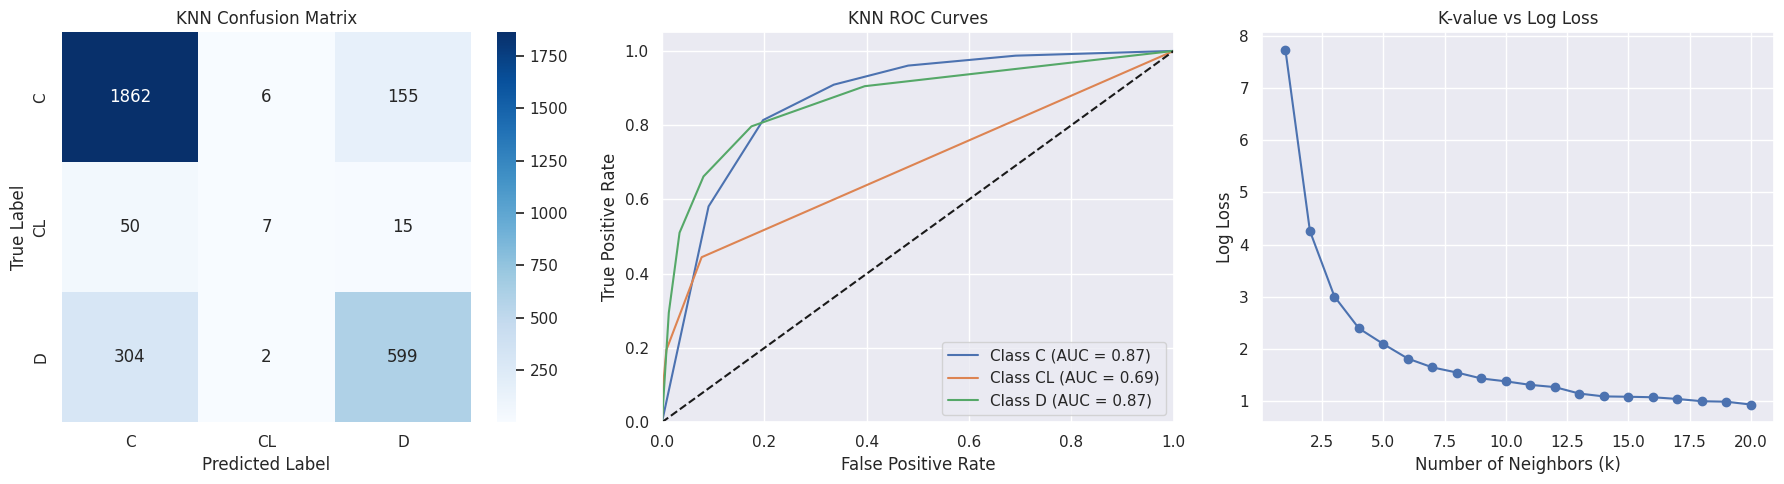


KNN Performance Metrics:
Log Loss: 2.0955
Accuracy: 0.8227
Macro F1-Score: 0.5850

Best k value: 20 with Log Loss: 0.9374


In [ ]:
knn_model = KNeighborsClassifier()

# train the model
knn_model.fit(X_train_processed, y_train)

# predict probabilities on the validation set
y_val_pred_knn = knn_model.predict_proba(X_val_processed)

# calculate log loss
knn_log_loss = log_loss(y_val, y_val_pred_knn)

print(f"KNN Log Loss: {knn_log_loss:.4f}")


best_k, best_loss = plot_model_performance(knn_model,
                                         X_train_processed,
                                         X_val_processed,
                                         y_train,
                                         y_val,
                                         "KNN")

## Naive Bayes

Naive Bayes Log Loss: 6.3836


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


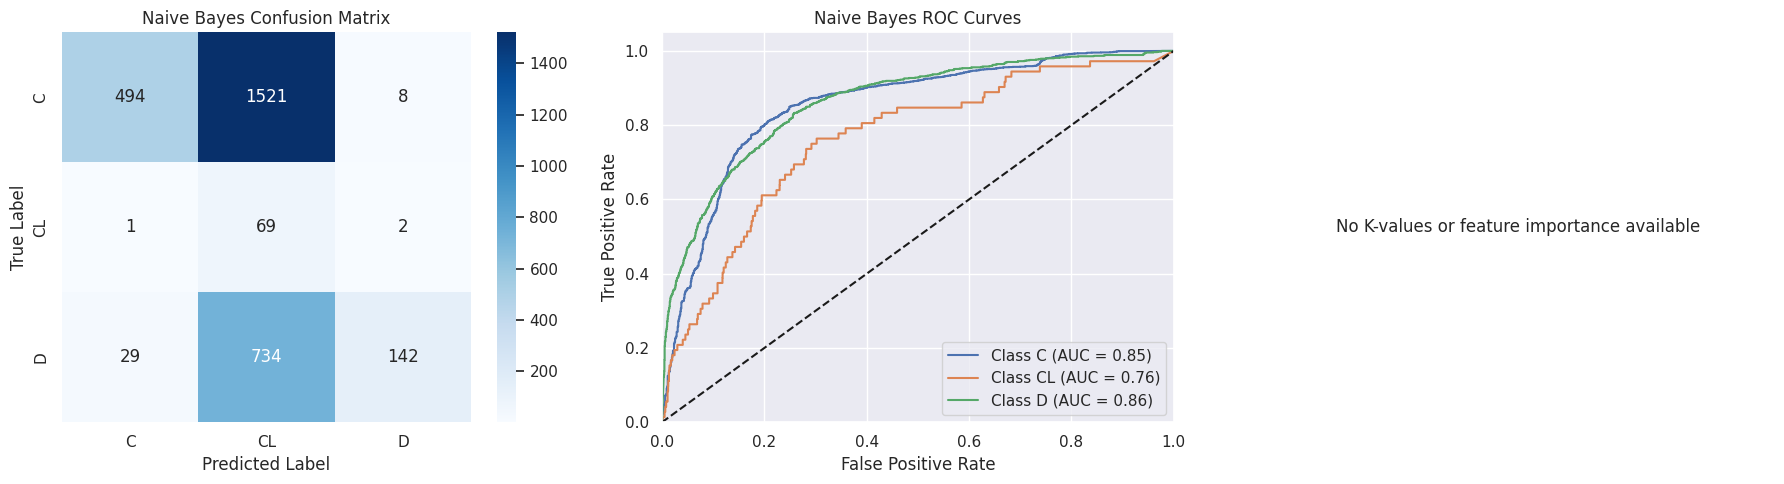


Naive Bayes Performance Metrics:
Log Loss: 6.3836
Accuracy: 0.2350
Macro F1-Score: 0.2381


In [ ]:
nb_model = GaussianNB()

# train the model
nb_model.fit(X_train_processed, y_train)

# predict probabilities on the validation set
y_val_pred_nb = nb_model.predict_proba(X_val_processed)

# calculate log loss
nb_log_loss = log_loss(y_val, y_val_pred_nb)

print(f"Naive Bayes Log Loss: {nb_log_loss:.4f}")

best_k, best_loss = plot_model_performance(nb_model,
                      X_train_processed,
                      X_val_processed,
                      y_train,
                      y_val,
                      "Naive Bayes")

## ID3

Decision Tree Log Loss: 7.9777


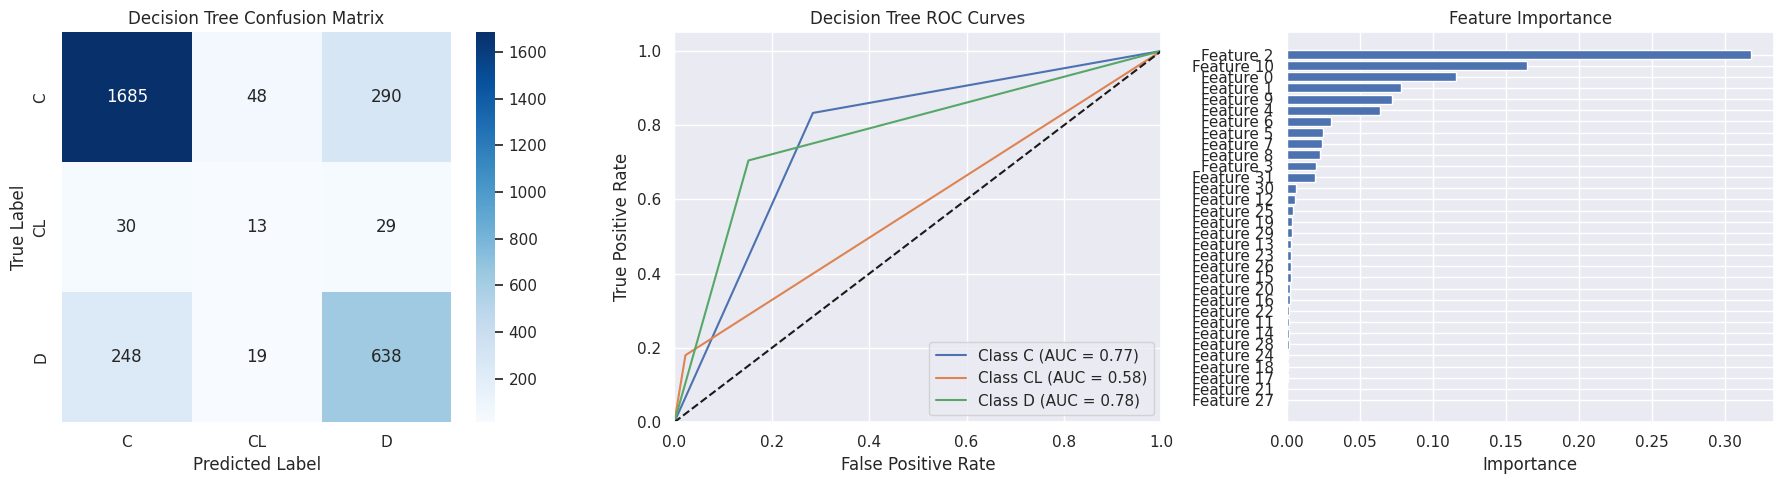


Decision Tree Performance Metrics:
Log Loss: 7.9777
Accuracy: 0.7787
Macro F1-Score: 0.5673


In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)

# train the model
dt_model.fit(X_train_processed, y_train)

# predict probabilities on the validation set
y_val_pred_dt = dt_model.predict_proba(X_val_processed)

# calculate log loss
dt_log_loss = log_loss(y_val, y_val_pred_dt)

print(f"Decision Tree Log Loss: {dt_log_loss:.4f}")

best_k, best_loss = plot_model_performance(dt_model,
                      X_train_processed,
                      X_val_processed,
                      y_train,
                      y_val,
                      "Decision Tree")

## SVM

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Log Loss: 0.4266


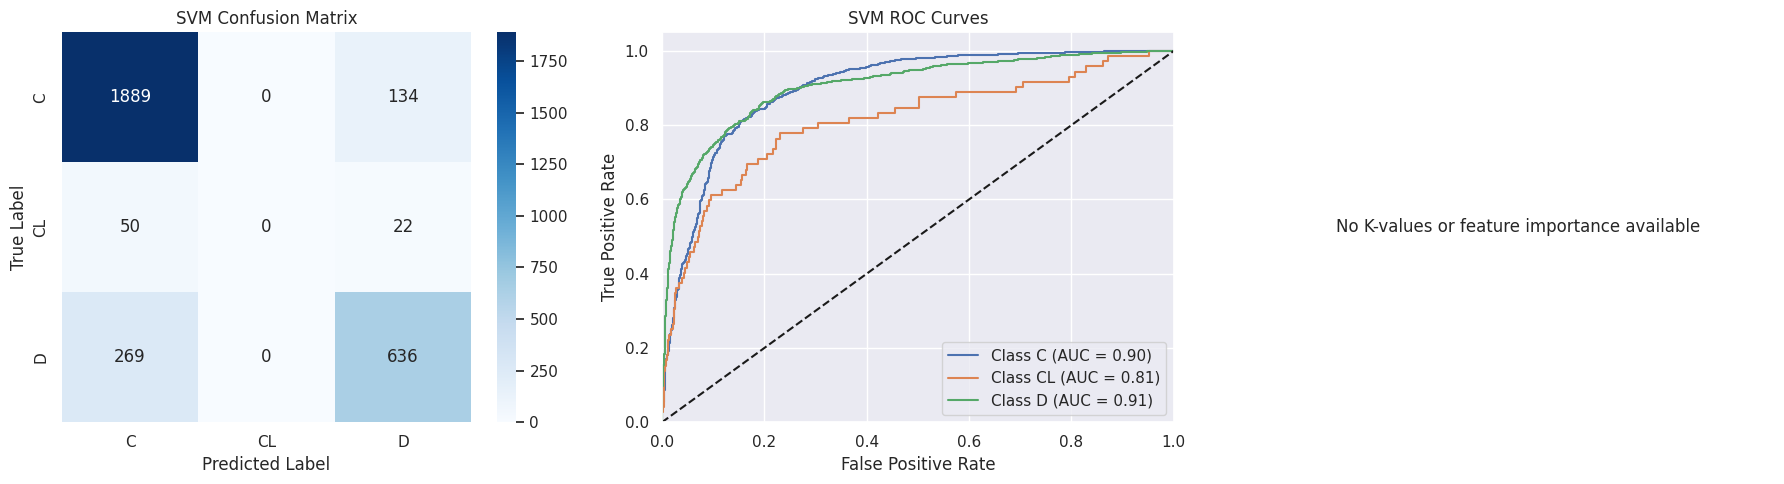


SVM Performance Metrics:
Log Loss: 0.4266
Accuracy: 0.8417
Macro F1-Score: 0.5475


In [ ]:
svm_model = SVC(probability=True, random_state=42)

# train the model
svm_model.fit(X_train_processed, y_train)

# predict probabilities on the validation set
y_val_pred_svm = svm_model.predict_proba(X_val_processed)

# calculate log loss
svm_log_loss = log_loss(y_val, y_val_pred_svm)

print(f"SVM Log Loss: {svm_log_loss:.4f}")

best_k, best_loss = plot_model_performance(svm_model,
                      X_train_processed,
                      X_val_processed,
                      y_train,
                      y_val,
                      "SVM")

## Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Log Loss: 0.4214


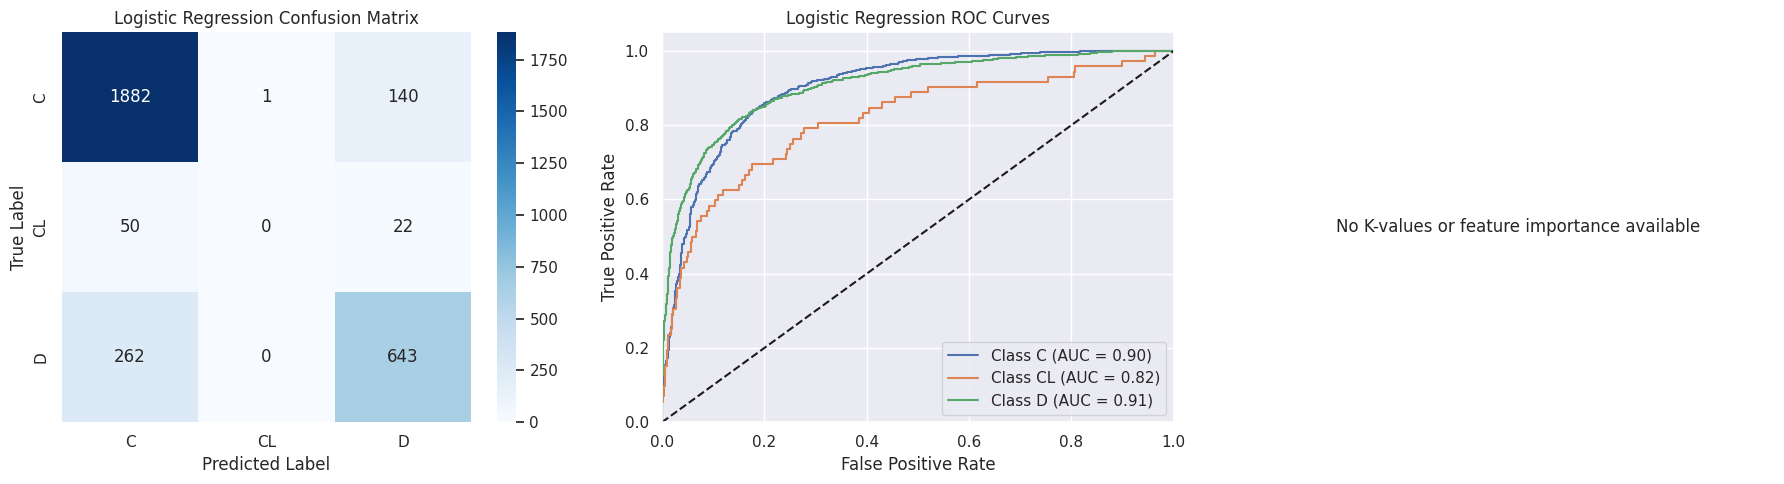


Logistic Regression Performance Metrics:
Log Loss: 0.4214
Accuracy: 0.8417
Macro F1-Score: 0.5482


In [ ]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# train the model
lr_model.fit(X_train_processed, y_train)

# predict probabilities on the validation set
y_val_pred_lr = lr_model.predict_proba(X_val_processed)

# calculate log loss
lr_log_loss = log_loss(y_val, y_val_pred_lr)

print(f"Logistic Regression Log Loss: {lr_log_loss:.4f}")

best_k, best_loss = plot_model_performance(lr_model,
                      X_train_processed,
                      X_val_processed,
                      y_train,
                      y_val,
                      "Logistic Regression")

## Catboost

Unique classes in y_train: ['C' 'CL' 'D']
0:	learn: 0.9836575	test: 0.9833901	best: 0.9833901 (0)	total: 41.8ms	remaining: 41.7s
100:	learn: 0.3578285	test: 0.3833191	best: 0.3833191 (100)	total: 3.11s	remaining: 27.7s
200:	learn: 0.3236351	test: 0.3759645	best: 0.3759185 (195)	total: 6.09s	remaining: 24.2s
300:	learn: 0.2990593	test: 0.3730932	best: 0.3728075 (293)	total: 9.48s	remaining: 22s
400:	learn: 0.2792804	test: 0.3698500	best: 0.3698500 (400)	total: 12.2s	remaining: 18.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3696169166
bestIteration = 410

Shrink model to first 411 iterations.
CatBoost Log Loss: 0.3696


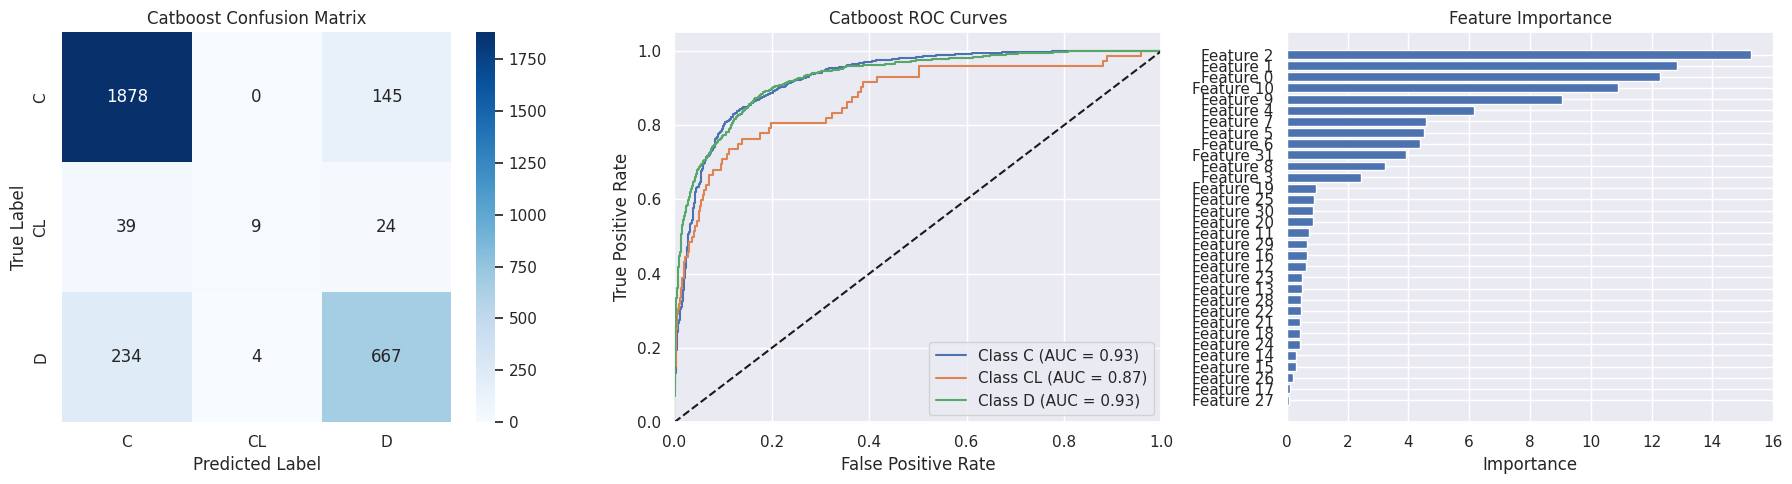


Catboost Performance Metrics:
Log Loss: 0.3696
Accuracy: 0.8513
Macro F1-Score: 0.6259


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss
import numpy as np

# First, let's check the unique classes in your target variable
print("Unique classes in y_train:", np.unique(y_train))

# Initialize CatBoost model with appropriate loss function
if len(np.unique(y_train)) == 2:
    # Binary classification
    catboost_model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.1,
        random_state=42,
        loss_function='Logloss',  # for binary classification
        eval_metric='Logloss',
        verbose=100
    )
else:
    # Multiclass classification
    catboost_model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.1,
        random_state=42,
        loss_function='MultiClass',  # for multiclass classification
        eval_metric='MultiClass',
        verbose=100
    )

# Train the model
catboost_model.fit(
    X_train_processed,
    y_train,
    eval_set=[(X_val_processed, y_val)],
    early_stopping_rounds=50,
    verbose=100
)

# Predict probabilities on validation set
y_val_pred_catboost = catboost_model.predict_proba(X_val_processed)

# Calculate log loss
catboost_log_loss = log_loss(y_val, y_val_pred_catboost)

print(f"CatBoost Log Loss: {catboost_log_loss:.4f}")

best_k, best_loss = plot_model_performance(catboost_model,
                      X_train_processed,
                      X_val_processed,
                      y_train,
                      y_val,
                      "Catboost")

## LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1995
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 32
[LightGBM] [Info] Start training from score -0.393784
[LightGBM] [Info] Start training from score -3.736670
[LightGBM] [Info] Start training from score -1.198433


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LightGBM Log Loss: 0.6357


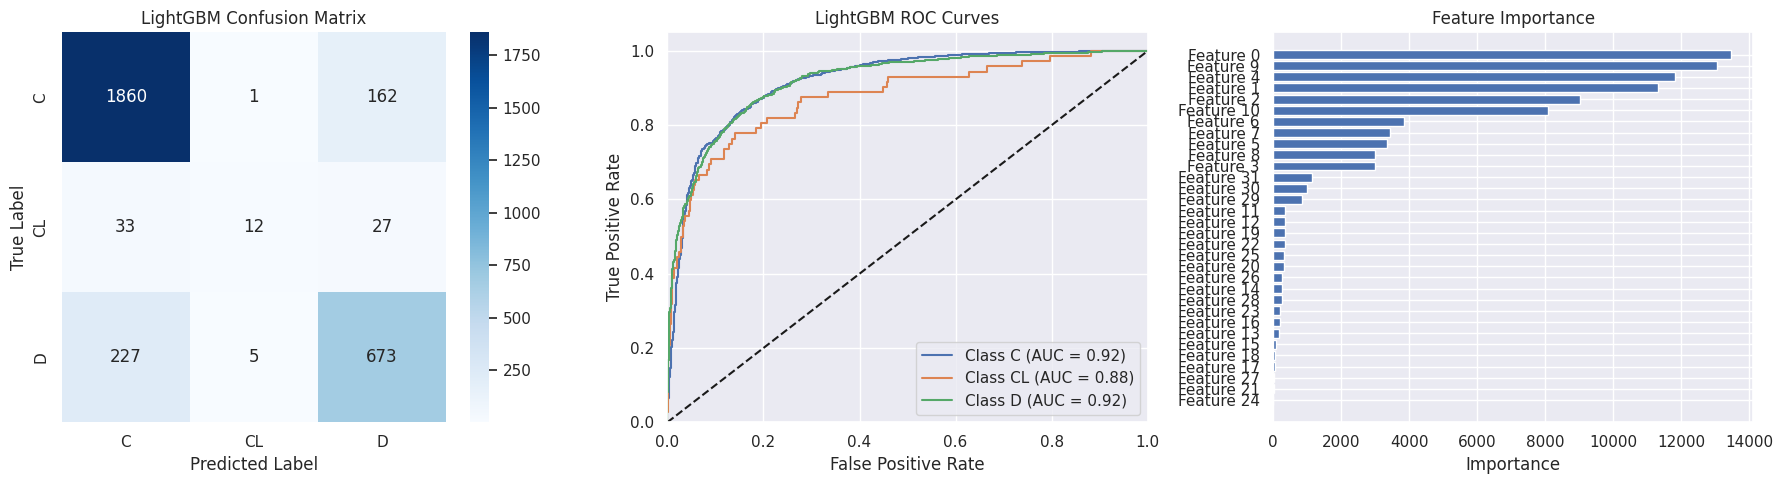


LightGBM Performance Metrics:
Log Loss: 0.6357
Accuracy: 0.8483
Macro F1-Score: 0.6421


In [ ]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    random_state=42
)
lgb_model.fit(X_train_processed, y_train)
lgb_pred = lgb_model.predict_proba(X_val_processed)
lgb_loss = log_loss(y_val, lgb_pred)

print(f"LightGBM Log Loss: {lgb_loss:.4f}")

best_k, best_loss = plot_model_performance(lgb_model,
                      X_train_processed,
                      X_val_processed,
                      y_train,
                      y_val,
                      "LightGBM")

## XGBoost

In [ ]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

# Create and fit the label encoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)  # Use transform, not fit_transform for validation data

# Now train XGBoost with encoded labels
xgb_model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X_train_processed, y_train_encoded)

# Get predictions
xgb_pred = xgb_model.predict_proba(X_val_processed)
xgb_loss = log_loss(y_val_encoded, xgb_pred)

print(f"XGBoost Log Loss: {xgb_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


XGBoost Log Loss: 0.4873


## Summary

In [ ]:
# log Loss results
log_loss_results = {
    'KNN': knn_log_loss,
    'Naive Bayes': nb_log_loss,
    'Decision Tree': dt_log_loss,
    'SVM': svm_log_loss,
    'Logistic Regression': lr_log_loss,
    'Catboost': catboost_log_loss,
    'LightGBM': lgb_loss,
    'XGBoost': xgb_loss
}

print("Log Loss Results:")
for model, loss in log_loss_results.items():
    print(f"{model}: {loss:.4f}")

# identify the best-performing model
best_model_name = min(log_loss_results, key=log_loss_results.get)
print(f"The best model is {best_model_name} with a Log Loss of {log_loss_results[best_model_name]:.4f}")

Log Loss Results:
KNN: 2.0955
Naive Bayes: 6.3836
Decision Tree: 7.9777
SVM: 0.4266
Logistic Regression: 0.4214
Catboost: 0.3696
LightGBM: 0.6357
XGBoost: 0.4873
The best model is Catboost with a Log Loss of 0.3696


## Notes for improvements

- **Visualize the model evaluation result**

This will help you to understand the details more clearly about your model's performance. From the visualization, you can see clearly if your model is leaning towards a class than the others. (Hint: confusion matrix, ROC-AUC curve, etc.)

- **Explore the hyperparameters of your models**

Each models have their own hyperparameters. And each of the hyperparameter have different effects on the model behaviour. You can optimize the model performance by finding the good set of hyperparameters through a process called **hyperparameter tuning**. (Hint: Grid search, random search, bayesian optimization)

- **Cross-validation**

Cross-validation is a critical technique in machine learning and data science for evaluating and validating the performance of predictive models. It provides a more **robust** and **reliable** evaluation method compared to a hold-out (single train-test set) validation. Though, it requires more time and computing power because of how cross-validation works. (Hint: k-fold cross-validation, stratified k-fold cross-validation, etc.)

- **Ensemble methods**

Ensemble methods are powerful machine learning techniques that combine the predictions of multiple models (often referred to as base learners or weak learners) to create a stronger, more accurate predictive model. The idea behind ensemble methods is that by aggregating the opinions of multiple models, you can reduce the impact of individual model errors and improve overall prediction performance. (Hint: bagging, boosting, stacking, voting)

- **Model interpretation**

Model interpretation is the process of understanding and explaining the inner workings of a machine learning model, particularly its decision-making process. Interpretation helps data scientists, stakeholders, and end-users gain insights into why a model makes certain predictions or classifications. Model interpretation is crucial for building trust in machine learning systems, identifying biases, and extracting actionable information from models. (Hint: Feature importance, PDP, SHAP Values, etc)

- **Explore other models**

There are a lot of ML models that you can use in this usecase. Try to explore and use them to solve this problem.

## Submission
To predict the test set target feature and submit the results to the kaggle competition platform, do the following:
1. Create a new pipeline instance identical to the first in Data Preprocessing
2. With the pipeline, apply `fit_transform` to the original training set before splitting, then only apply `transform` to the test set.
3. Retrain the model on the preprocessed training set
4. Predict the test set
5. Make sure the submission contains the `id`, `Status_C`, `Status_CL`, `Status_D` column.

In [ ]:
# Function to identify numerical columns with skewness
def identify_skewed_features(df, numerical_columns, threshold=0.5):
    skewed_features = []
    for col in numerical_columns:
        if abs(df[col].skew()) > threshold:
            skewed_features.append(col)
    return skewed_features

# Function to preprocess data
def create_preprocessor(X, numerical_columns, categorical_columns):
    # Identify skewed features
    skewed_features = identify_skewed_features(X[numerical_columns], numerical_columns)

    # Create specific pipeline for skewed features
    skewed_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('power_transform', PowerTransformer(method='yeo-johnson')),  # specifically for skewed data
        ('scaler', RobustScaler())
    ])

    # Normal numerical features
    normal_numerical = [col for col in numerical_columns if col not in skewed_features]

    # Create the full preprocessor
    preprocessor = ColumnTransformer([
        ('num_normal', numerical_pipeline, normal_numerical),
        ('num_skewed', skewed_pipeline, skewed_features),
        ('cat', categorical_pipeline, categorical_columns)
    ])

    return preprocessor

In [ ]:
model_mapping = {
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Catboost': CatBoostClassifier(
        iterations=1000,
        learning_rate=0.1,
        random_state=42,
        loss_function='MultiClass',
        eval_metric='MultiClass',
        verbose=10),
    'LightGBM': LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.1,
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=1000,
        learning_rate=0.1,
        random_state=42
    )
}

full_preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, num_columns),
    ('cat', categorical_pipeline, cat_columns)
])


test = test[x_train.columns]  # Align test columns with training columns
test_ids = test['id']

# Initialize the preprocessor
full_preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, num_columns),
    ('cat', categorical_pipeline, cat_columns)
])

full_preprocessor.fit(x_train)
# Transform the test data using the fitted preprocessor
X_full_processed = full_preprocessor.fit_transform(x_train)  # entire training set
test_processed = full_preprocessor.transform(test)

best_model = model_mapping[best_model_name]
best_model.fit(X_full_processed, y_train)

if best_model_name == 'Naive Bayes':
    test_predictions = best_model.predict_proba(test_processed)
else:
    test_predictions = best_model.predict_proba(test_processed)

# prepare the submission dataframe
submission = pd.DataFrame(test_predictions, columns=best_model.classes_)
submission['id'] = test_ids
submission = submission[['id'] + list(best_model.classes_)]  # ensure correct column order

submission.rename(columns={
    'C': 'Status_C',
    'CL': 'Status_CL',
    'D': 'Status_D'
}, inplace=True)

# save the submission file
submission.to_csv('submission7.csv', index=False)

print(f"Submission file created using {best_model_name}")

0:	learn: 0.9836575	total: 30.6ms	remaining: 30.6s
10:	learn: 0.5483365	total: 320ms	remaining: 28.8s
20:	learn: 0.4479864	total: 589ms	remaining: 27.5s
30:	learn: 0.4123202	total: 871ms	remaining: 27.2s
40:	learn: 0.3962196	total: 1.16s	remaining: 27.2s
50:	learn: 0.3858908	total: 1.41s	remaining: 26.3s
60:	learn: 0.3778504	total: 1.61s	remaining: 24.8s
70:	learn: 0.3723252	total: 1.74s	remaining: 22.8s
80:	learn: 0.3674979	total: 1.87s	remaining: 21.2s
90:	learn: 0.3624731	total: 2s	remaining: 20s
100:	learn: 0.3578285	total: 2.13s	remaining: 19s
110:	learn: 0.3538788	total: 2.26s	remaining: 18.1s
120:	learn: 0.3487487	total: 2.42s	remaining: 17.5s
130:	learn: 0.3445736	total: 2.58s	remaining: 17.1s
140:	learn: 0.3419779	total: 2.71s	remaining: 16.5s
150:	learn: 0.3387452	total: 2.84s	remaining: 15.9s
160:	learn: 0.3353535	total: 2.97s	remaining: 15.5s
170:	learn: 0.3316867	total: 3.1s	remaining: 15s
180:	learn: 0.3283123	total: 3.23s	remaining: 14.6s
190:	learn: 0.3262211	total: 3.3

# 6. Error Analysis

Based on all the process you have done until the modeling and evaluation step, write an analysis to support each steps you have taken to solve this problem. Write the analysis using the markdown block. Some questions that may help you in writing the analysis:

- Does my model perform better in predicting one class than the other? If so, why is that?
- To each models I have tried, which performs the best and what could be the reason?
- Is it better for me to impute or drop the missing data? Why?
- Does feature scaling help improve my model performance?

**DATA IMBALANCE**

Data imbalance merupakan ketidakseimbangan proporsi data, seperti misalnya dari 3 status yang ada (C, CL, dan D), salah satu atau beberapanya memiliki jumlah yang jauh lebih banyak dibandingkan kelas yang lain (dalam hal ini,  kelas C jauh lebih banyak dibandingkan CL dan D), sehingga mempengaruhi performa model secara signifikan, khususnya dalam hal kemampuan model untuk mengenali kelas dengan jumlah data yang lebih sedikit. Model menjadi "terbiasa" dengan kelas mayoritas, sehingga menjadi bias.

**MISSING VALUES**

Dataset memiliki banyak missing values, yang jika tidak ditangani dengan benar, model dapat kehilangan informasi penting yang dibutuhkan untuk belajar dari data. Model mungkin mempelajari pola yang tidak lengkap atau bias jika nilai yang hilang tidak digantikan atau diproses dengan benar.

Hal yang kami lakukan pertama adalah mencoba untuk menghapus data-data missing values ini, namun ternyata hasilnya malah lebih buruk. Terdapat beribu-ribu data yang hilang dan membuat data tidak akurat.

Akhirnya kami memutuskan untuk mengisi nilai yang hilang tersebut dengan median  (untuk numerical) dan mengisi dengan nilai konstan ‘missing’ (untuk categorical) pada pipeline.

**OUTLIERS**

Penanganan outliers sebenarnya ada bermacam-macam. Untuk numerical data dapat diganti dengan mean, median, ataupun modus. Selain itu juga dapat menggunakan metode clipping dan metode untuk mengganti value outliers ke value yang paling dekat dengan outliers tersebut. Namun setelah kami mencoba semua hal tersebut, hasil model lebih baik apabila outliers tidak diganti. Maka dari itu kami memutuskan untuk membiarkan nilai-nilai outliers tersebut.

# Daftar Perubahan


*   Mengubah algoritma untuk splitting dengan menggunakan Hold-out Validation (sebelumnya menggunakan Bootstrap Validation)
*   Menambah model baru untuk train data. Hasil log less yang paling kecil adalah Catboost sehingga kami mengubah algoritmanya menggunakan Catboost (sebelumnya menggunakan Logistic Regression)
*   Menambah plot *confusion matrix* dan *ROC curves* cuntuk setiap model
*   Menambah *error analysis*

